#### Import the Necessary Packages

In [1]:
import os
import sys
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Get the current working directory
current_folder = os.getcwd()

# # Add a relative path (e.g., parent folder or a specific subfolder)
SpeedNet_model_folder = os.path.abspath(os.path.join(current_folder, "../../SpeedNet_model"))
sys.path.append(SpeedNet_model_folder)

hsemetric_folder = os.path.abspath(os.path.join(current_folder, "../../HSEMETRIC"))
sys.path.append(hsemetric_folder)


# Now import the module
import SpeedNet_model_prep #(I created the package to allow easy flow extraction from the pretrained model)
import hsemetric        #(This package was created by Upendra et al. 2020)


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from keras.models import load_model

import pandas as pd
import numpy as np
import glob 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from astropy.io import fits 
import cv2

import datetime
from datetime import datetime

#### Grad-Cam Heatmap Activation Function

In [3]:
def gradcamm(img_array, best_model):
    # First part
    last_conv_layer_name = "max_pooling2d_3"
    last_conv_layer = best_model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(best_model.inputs, last_conv_layer.output)
    
    # Second part _ LSTM Regressor
    regression_layer_names = [
       "flatten",
       "reshape",
       "lstm",
       "dense",
       "dense_1",
    ]
    
    lstm_regressor_input = Input(shape=(14, 14, 128))
    x = lstm_regressor_input
    for layer_name in regression_layer_names:
        x = best_model.get_layer(layer_name)(x)
    regressor_model = Model(lstm_regressor_input, x)
    
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        preds = regressor_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()
    
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    for i in range(128):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    heatmap = np.sum(last_conv_layer_output, axis=-1)
    heatmap = tf.nn.relu(heatmap)
    resized_heatmap = cv2.resize(np.array(heatmap), (256,256))
    return resized_heatmap, preds
    

##### Evaluation Metrics 

In [4]:
def rmse_corr_metrics(a_obs, b_preds):
    best_mae = mean_absolute_error(a_obs.dropna(), b_preds.dropna())
    best_mse = mean_squared_error(a_obs.dropna(), b_preds.dropna())
    best_rmse = root_mean_squared_error(a_obs.dropna(), b_preds.dropna())
    corr_matrix = np.corrcoef(a_obs.dropna(), b_preds.dropna())
    corr_coef = corr_matrix[0, 1]
    
    # Fisher transformation for uncertainty
    z = 0.5 * np.log((1 + corr_coef) / (1 - corr_coef))
    n = len(a_obs.dropna())
    se = 1 / np.sqrt(n - 3)
    z_conf_interval = se * 1.96  # 95% confidence interval
    pearson_conf_interval = 1.96 * (1 / np.sqrt(n - 3))
    pearson_uncertainty = np.tanh(z_conf_interval)
    
    # Uncertainty in MSE
    mse_uncertainty = np.sqrt(2 * best_mse ** 2 / n) 
    # Uncertainty in RMSE
    rmse_uncertainty = 0.5 * mse_uncertainty / best_rmse

    tp,fp,fn= hsemetric.BatchwiseHSE(np.array(a_obs.dropna()), np.array(b_preds.dropna()))
    threat_score=tp*1.0/(tp+fp+fn)
    print(f'TP: {tp} \nFP: {fp} \nFN: {fn}')
    return best_rmse, rmse_uncertainty, corr_coef, pearson_uncertainty, threat_score

#### Linear Fit

In [5]:
def linear_fit(df):
    """
    This function calculates the linear fit between the solar wind prediction and observed.
    and returns
    int{obs_cleaned}: The observed solar wind speed,
    int{pred_cleaned}: The predicted solar wind speed
    int{fitted_y}: The linear fit
    int{slope}: slope
    int{intercept} : intercept
    """
    df_cleaned = df.dropna()

    # Extract cleaned x and y
    obs_cleaned = df_cleaned["test_original"]
    pred_cleaned = df_cleaned["test_predicted"]
    slope, intercept = np.polyfit(obs_cleaned, pred_cleaned, 1)
    
    # Generate the fitted line
    fitted_y = slope * obs_cleaned + intercept

    return obs_cleaned, pred_cleaned, fitted_y, slope, intercept 

##### CSV FILE FUNCTION (FOR SAVING THE SW (Pred/Obs) from the Trained Model)

In [6]:
def save_data_csv(test_timestamps_output, test_velocity_out, best_pred, phase, fold_index, num_delay, n_steps=1):
    """
    test_timestamps_output: list of timestamp
    test_velocity_out: list of the original values
    best_pred: list of prediction
    phase: STRING --> solar cycle phase
    fold_index: cross-validation fold
    num_delay: data adapation delay; note that index starts from 0.
    n_steps: Default timesteps is equal to 1.
    """
    data_pred = {
            'date': test_timestamps_output[(n_steps-1):],
            'test_original': tf.squeeze(test_velocity_out[(n_steps-1):]),
            'test_predicted': tf.squeeze(best_pred)
        }
    pred_df = pd.DataFrame(data_pred)

    # Create a complete date range from the minimum to the maximum date in the data
    pred_date_range = pd.date_range(start=pred_df['date'].min(), end=pred_df['date'].max())

    # Reindex the DataFrame to insert NaN for missing dates
    pred_df = pred_df.set_index('date').reindex(pred_date_range).rename_axis('date').reset_index()

    pred_df.to_csv(f'{phase}_{fold_index}_and_delay_{num_delay+1}.csv', index=False)

In [7]:
def real_test_data(colored_file_path, fold_index, num_delay_index, Solar_phase, Test_image_cnn_date):
    real_test_filename = sorted(glob.glob(f"{colored_file_path}/**"))
    real_test_images = []
    
    for real_test_file in real_test_filename:
        #  Extract the Date of the Image 
        f_test_name = real_test_file[-8:]
      
        # Convert the String Date to Datetime Format
        solar_date_test = datetime.strptime(f_test_name,'%Y%m%d')
        # print(solar_date_test)
      
        # SELECT ONLY THE TEST IMAGE BASED ON THE DATE
        if solar_date_test in Test_image_cnn_date:
            hdu_img = fits.open(real_test_file)
            img = hdu_img[0].data
            real_test_images.append(img)
    image_testset_array = np.array(real_test_images)
    np.save(f'{Solar_phase}_test_fold_{fold_index}_and_delay_{num_delay_index+1}.npy', image_testset_array)
      


### ASCENDING

In [ ]:
n_steps = 1
fold_index = 3
ascending_num_delay = 3
path = "/home/joseph/DL/DATASET"
train_start_date = "2010-05-13"
train_end_date = "2011-07-06"
test_start_date = "2011-07-07"
test_end_date = "2011-12-31"
img_train_path = "/home/joseph/DL/DATASET/ASCENDING_PHASE_BINARY/Train"
img_test_path = "/home/joseph/DL/DATASET/ASCENDING_PHASE_BINARY/Test"

# Prepare the Timeseries data 
df, velocity_train, velocity_test, std_velocity_test, train_speed_dates, test_speed_dates, full_icme_list = SpeedNet_model_prep.load_df(path, train_start_date,
                                                                                                                                        train_end_date, test_start_date, 
                                                                                                                                        test_end_date)
# Returns the Solar Map Dates (Timestamps) after ICME FILTERATION
map_train_non_icme_date, map_test_non_icme_date = SpeedNet_model_prep.non_icme_Image_date(img_train_path, img_test_path, full_icme_list)

# ADAPTS THE FILTERED SW AND MAP DATES BY RETURNING THE NEW INDEX 
Speed_train_indices, Speed_test_indices, solar_image_train_indices, solar_image_test_indices = SpeedNet_model_prep.time_adaptation_delay_prep(train_start_date, train_end_date,
                                                                                                                                              test_start_date, test_end_date,
                                                                                                                                              train_speed_dates, test_speed_dates,
                                                                                                                                              map_train_non_icme_date, map_test_non_icme_date)

# Preparing the Training Dates BY ADAPTING WITH THE TIME DELAY
ascending_Train_image_cnn_date, ascending_Train_timeseries_date, ascending_Train_output_timeseries_date = SpeedNet_model_prep.match_data_prep(ascending_num_delay,
                                                                                                                                              n_steps, map_train_non_icme_date,
                                                                                                                                              train_speed_dates, 
                                                                                                                                              solar_image_train_indices, Speed_train_indices)    
# Preparing the Testing Dates BY ADAPTING WITH THE TIME DELAY
ascending_Test_image_cnn_date, ascending_Test_timeseries_date, ascending_Test_output_timeseries_date = SpeedNet_model_prep.match_data_prep(ascending_num_delay,
                                                                                                                                           n_steps, map_test_non_icme_date,
                                                                                                                                           test_speed_dates,
                                                                                                                                           solar_image_test_indices, Speed_test_indices)
# Using the New SW datetime (Prepare the timeseries (Train, Test, Test:Timestamps))
ascending_train_velocity_out, ascending_test_velocity_out, ascending_test_timestamps_output = SpeedNet_model_prep.filter_output(df, ascending_Train_output_timeseries_date, ascending_Test_output_timeseries_date)

# Using the New Map datetime (Prepare the MAPS (Train, Test))
ascending_train_images, ascending_test_images =  SpeedNet_model_prep.train_test_set(img_train_path, img_test_path, ascending_Train_image_cnn_date, ascending_Test_image_cnn_date)

# Load the Pretrained Model
best_model_ascending = load_model(f"/home/joseph/DL/SpeedNet-BM/ASCENDING/best_model_for_fold_{fold_index}_timestep_{n_steps}_and_delay_{ascending_num_delay}.keras")

# Pretrained Model Prediction
best_pred_ascending = best_model_ascending.predict(ascending_test_images)

# Save the Prediction together with the Observation as CSV File
Ascending_save_to_csv = save_data_csv(ascending_test_timestamps_output, ascending_test_velocity_out, best_pred_ascending, "ASCENDING_PHASE", fold_index, ascending_num_delay, n_steps=1)

# Load the corresponding Standardized Map (For Visualization Purpose)
# Save the File as .npy (numpy Array)
Ascending_stand_img_file_path = "/home/joseph/DL/DATASET/ASCENDING_PHASE_COLORED/Test"
Ascending_save_original_standardized_image = real_test_data(Ascending_stand_img_file_path, fold_index, ascending_num_delay, "ASCENDING_PHASE", ascending_Test_image_cnn_date)


### MAXIMUM

In [ ]:
n_steps = 1
fold_index = 1
maximum_num_delay = 3
path = "/home/joseph/DL/DATASET"
train_start_date = "2012-01-01"
train_end_date = "2014-02-01"
test_start_date = "2014-02-02"
test_end_date = "2014-12-31"
img_train_path = "/home/joseph/DL/DATASET/MAXIMUM_PHASE_BINARY/Train"
img_test_path = "/home/joseph/DL/DATASET/MAXIMUM_PHASE_BINARY/Test"

# Prepare the Timeseries data 
df, velocity_train, velocity_test, std_velocity_test, train_speed_dates, test_speed_dates, full_icme_list = SpeedNet_model_prep.load_df(path, train_start_date,
                                                                                                                                        train_end_date, test_start_date, 
                                                                                                                                        test_end_date)

# Returns the Solar Map Dates (Timestamps) after ICME FILTERATION
map_train_non_icme_date, map_test_non_icme_date = SpeedNet_model_prep.non_icme_Image_date(img_train_path, img_test_path, full_icme_list)

# ADAPTS THE FILTERED SW AND MAP DATES BY RETURNING THE NEW INDEX 
Speed_train_indices, Speed_test_indices, solar_image_train_indices, solar_image_test_indices = SpeedNet_model_prep.time_adaptation_delay_prep(train_start_date, train_end_date,
                                                                                                                                               test_start_date, test_end_date,
                                                                                                                                               train_speed_dates, test_speed_dates,
                                                                                                                                               map_train_non_icme_date, map_test_non_icme_date)

# Preparing the Training Dates BY ADAPTING WITH THE TIME DELAY
maximum_Train_image_cnn_date, maximum_Train_timeseries_date, maximum_Train_output_timeseries_date = SpeedNet_model_prep.match_data_prep(maximum_num_delay,
                                                                                                                                        n_steps, map_train_non_icme_date, 
                                                                                                                                        train_speed_dates, 
                                                                                                                                        solar_image_train_indices, Speed_train_indices)    

# Preparing the Testing Dates BY ADAPTING WITH THE TIME DELAY
maximum_Test_image_cnn_date, maximum_Test_timeseries_date, maximum_Test_output_timeseries_date = SpeedNet_model_prep.match_data_prep(maximum_num_delay,
                                                                                                                                     n_steps, map_test_non_icme_date,
                                                                                                                                     test_speed_dates,
                                                                                                                                     solar_image_test_indices, Speed_test_indices)

# Using the New SW datetime (Prepare the timeseries (Train, Test, Test:Timestamps))
maximum_train_velocity_out, maximum_test_velocity_out, maximum_test_timestamps_output = SpeedNet_model_prep.filter_output(df, maximum_Train_output_timeseries_date, maximum_Test_output_timeseries_date)

# Using the New Map datetime (Prepare the MAPS (Train, Test))
maximum_train_images, maximum_test_images =  SpeedNet_model_prep.train_test_set(img_train_path, img_test_path, maximum_Train_image_cnn_date, maximum_Test_image_cnn_date)

# Load the Pretrained Model
best_model_maximum = load_model(f"/home/joseph/DL/SpeedNet-BM/MAXIMUM/best_model_for_fold_{fold_index}_timestep_{n_steps}_and_delay_{maximum_num_delay}.keras")

# Pretrained Model Prediction
best_pred_maximum = best_model_maximum.predict(maximum_test_images)

# Save the Prediction together with the Observation as CSV File
Maximum_save_to_csv = save_data_csv(maximum_test_timestamps_output, maximum_test_velocity_out, best_pred_maximum, "MAXIMUM_PHASE", fold_index, maximum_num_delay, n_steps=1)

# Load the corresponding Standardized Map (For Visualization Purpose)
# Save the File as .npy (numpy Array)
maximum_stand_img_file_path = "/home/joseph/DL/DATASET/MAXIMUM_PHASE_COLORED/Test"
maximum_save_original_standardized_image = real_test_data(maximum_stand_img_file_path, fold_index, maximum_num_delay, "MAXIMUM_PHASE", maximum_Test_image_cnn_date)
 

### DECLINING

In [8]:
n_steps = 1
fold_index = 1
decline_num_delay = 4
path = "/home/joseph/DL/DATASET"
train_start_date = "2015-01-01"
train_end_date = "2017-12-31"
test_start_date = "2018-01-01"
test_end_date = "2018-12-31"
img_train_path = "/home/joseph/DL/DATASET/DECLINING_PHASE_BINARY/Train"
img_test_path = "/home/joseph/DL/DATASET/DECLINING_PHASE_BINARY/Test"

# Prepare the Timeseries data 
df, velocity_train, velocity_test, std_velocity_test, train_speed_dates, test_speed_dates, full_icme_list = SpeedNet_model_prep.load_df(path, train_start_date,
                                                                                                                                        train_end_date, test_start_date, 
                                                                                                                                        test_end_date)

# Returns the Solar Map Dates (Timestamps) after ICME FILTERATION
map_train_non_icme_date, map_test_non_icme_date = SpeedNet_model_prep.non_icme_Image_date(img_train_path, img_test_path, full_icme_list)

# ADAPTS THE FILTERED SW AND MAP DATES BY RETURNING THE NEW INDEX 
Speed_train_indices, Speed_test_indices, solar_image_train_indices, solar_image_test_indices = SpeedNet_model_prep.time_adaptation_delay_prep(train_start_date, train_end_date,
                                                                                                                                               test_start_date, test_end_date,
                                                                                                                                               train_speed_dates, test_speed_dates,
                                                                                                                                               map_train_non_icme_date, map_test_non_icme_date)
# Preparing the Training Dates BY ADAPTING WITH THE TIME DELAY
declining_Train_image_cnn_date, declining_Train_timeseries_date, declining_Train_output_timeseries_date = SpeedNet_model_prep.match_data_prep(decline_num_delay,
                                                                                                                                              n_steps, map_train_non_icme_date,
                                                                                                                                              train_speed_dates, 
                                                                                                                                              solar_image_train_indices, Speed_train_indices) 
# Preparing the Testing Dates BY ADAPTING WITH THE TIME DELAY   
declining_Test_image_cnn_date, declining_Test_timeseries_date, declining_Test_output_timeseries_date = SpeedNet_model_prep.match_data_prep(decline_num_delay,
                                                                                                                                           n_steps, map_test_non_icme_date,
                                                                                                                                           test_speed_dates,
                                                                                                                                           solar_image_test_indices, Speed_test_indices)

# Using the New SW datetime (Prepare the timeseries (Train, Test, Test:Timestamps))
declining_train_velocity_out, declining_test_velocity_out, declining_test_timestamps_output = SpeedNet_model_prep.filter_output(df, declining_Train_output_timeseries_date, declining_Test_output_timeseries_date)

# Using the New Map datetime (Prepare the MAPS (Train, Test))
declining_train_images, declining_test_images =  SpeedNet_model_prep.train_test_set(img_train_path, img_test_path, declining_Train_image_cnn_date, declining_Test_image_cnn_date)

# Load the Pretrained Model
best_model_declining = load_model(f"/home/joseph/DL/SpeedNet-BM/DECLINING/best_model_for_fold_{fold_index}_timestep_{n_steps}_and_delay_{decline_num_delay}.keras")

# Pretrained Model Prediction
best_pred_declining = best_model_declining.predict(declining_test_images)

# Save the Prediction together with the Observation as CSV File
declining_save_to_csv = save_data_csv(declining_test_timestamps_output, declining_test_velocity_out, best_pred_declining, "DECLINING_PHASE", fold_index, decline_num_delay, n_steps=1)

# Load the corresponding Standardized Map (For Visualization Purpose)
# Save the File as .npy (numpy Array)
declining_stand_img_file_path = "/home/joseph/DL/DATASET/DECLINING_PHASE_COLORED/Test"
declining_save_original_standardized_image = real_test_data(declining_stand_img_file_path, fold_index, decline_num_delay, "DECLINING_PHASE", declining_Test_image_cnn_date)

### MINIMUM

In [10]:
n_steps = 1
fold_index = 4
Minimum_num_delay = 2
path = "/home/joseph/DL/DATASET"
train_start_date = "2019-01-01"
train_end_date = "2020-05-26"
test_start_date = "2020-05-27"
test_end_date = "2020-12-31"
img_train_path = "/home/joseph/DL/DATASET/MINIMUM_PHASE_BINARY/Train"
img_test_path =  "/home/joseph/DL/DATASET/MINIMUM_PHASE_BINARY/Test"

# Prepare the Timeseries data 
df, velocity_train, velocity_test, std_velocity_test, train_speed_dates, test_speed_dates, full_icme_list = SpeedNet_model_prep.load_df(path, train_start_date,
                                                                                                                                        train_end_date, test_start_date, 
                                                                                                                                        test_end_date)

# Returns the Solar Map Dates (Timestamps) after ICME FILTERATION
map_train_non_icme_date, map_test_non_icme_date = SpeedNet_model_prep.non_icme_Image_date(img_train_path, img_test_path, full_icme_list)

# ADAPTS THE FILTERED SW AND MAP DATES BY RETURNING THE NEW INDEX 
Speed_train_indices, Speed_test_indices, solar_image_train_indices, solar_image_test_indices = SpeedNet_model_prep.time_adaptation_delay_prep(train_start_date, train_end_date,
                                                                                                                                               test_start_date, test_end_date,
                                                                                                                                               train_speed_dates, test_speed_dates,
                                                                                                                                               map_train_non_icme_date, map_test_non_icme_date)

# Preparing the Training Dates BY ADAPTING WITH THE TIME DELAY
Minimum_Train_image_cnn_date, Minimum_Train_timeseries_date, Minimum_Train_output_timeseries_date = SpeedNet_model_prep.match_data_prep(Minimum_num_delay,
                                                                                                                                        n_steps, map_train_non_icme_date,
                                                                                                                                        train_speed_dates, 
                                                                                                                                        solar_image_train_indices, Speed_train_indices) 

# Preparing the Testing Dates BY ADAPTING WITH THE TIME DELAY  
Minimum_Test_image_cnn_date, Minimum_Test_timeseries_date, Minimum_Test_output_timeseries_date = SpeedNet_model_prep.match_data_prep(Minimum_num_delay,
                                                                                                                                     n_steps, map_test_non_icme_date,
                                                                                                                                     test_speed_dates,
                                                                                                                                     solar_image_test_indices, Speed_test_indices)

# Using the New SW datetime (Prepare the timeseries (Train, Test, Test:Timestamps)) 
Minimum_train_velocity_out, Minimum_test_velocity_out, Minimum_test_timestamps_output = SpeedNet_model_prep.filter_output(df, Minimum_Train_output_timeseries_date, Minimum_Test_output_timeseries_date)

# Using the New Map datetime (Prepare the MAPS (Train, Test))
Minimum_train_images, Minimum_test_images =  SpeedNet_model_prep.train_test_set(img_train_path, img_test_path, Minimum_Train_image_cnn_date, Minimum_Test_image_cnn_date)

# Load the Pretrained Model
best_model_Minimum = load_model(f"/home/joseph/DL/SpeedNet-BM/MINIMUM/best_model_for_fold_{fold_index}_timestep_{n_steps}_and_delay_{Minimum_num_delay}.keras")

# Pretrained Model Prediction
best_pred_Minimum = best_model_Minimum.predict(Minimum_test_images)

# Save the Prediction together with the Observation as CSV File
Minimum_save_to_csv = save_data_csv(Minimum_test_timestamps_output, Minimum_test_velocity_out, best_pred_Minimum, "MINIMUM_PHASE", fold_index, Minimum_num_delay, n_steps=1)

# Load the corresponding Standardized Map (For Visualization Purpose)
# Save the File as .npy (numpy Array)
minimum_stand_img_file_path = "/home/joseph/DL/DATASET/MINIMUM_PHASE_COLORED/Test"
minimum_save_original_standardized_image = real_test_data(minimum_stand_img_file_path, fold_index, Minimum_num_delay, "MINIMUM_PHASE", Minimum_Test_image_cnn_date)
   

### Further Prep

In [ ]:
### Visualizing the Best predicition (Uniform across all cases.)
# 1. Ascending Indexing

ascending_max = np.argmax(ascending_test_velocity_out)
ascending_min = np.argmin(ascending_test_velocity_out)
ascending_indices_rand = [ascending_max-1, ascending_max, ascending_max+1, ascending_min, ascending_min+1]

# Load the correspond standardized .npy file (Ascending Phase)
ascending_loaded_array = np.load(f'ASCENDING_PHASE_test_fold_3_and_delay_4.npy')
# Based on the Ascending Phase Index, Index the loaded array (standardized)
ascending_standardized_set = ascending_loaded_array[ascending_indices_rand]
# Based on the Ascending Phase Index, Index the Binary Map
ascending_random_selection = ascending_test_images[ascending_indices_rand]
# Ascending Observed SW speed based on the Above indexing
ascending_orig_value = ascending_test_velocity_out[ascending_indices_rand]
# Ascending Timestamp based on the Above indexing
ascending_test_plot_date = pd.to_datetime(list(ascending_Test_timeseries_date)[ascending_indices_rand[1]]).date[0]

# 2. Maximum Indexing
Maximum_max = np.argmax(maximum_test_velocity_out)
Maximum_min = np.argmin(maximum_test_velocity_out)
Maximum_indices_rand = [Maximum_max-1, Maximum_max, Maximum_max+1, Maximum_min, Maximum_min+1]

# Load the correspond standardized .npy file (Maximum Phase)
maximum_loaded_array = np.load(f'MAXIMUM_PHASE_test_fold_1_and_delay_4.npy')
# Based on the Maximum Phase Index, Index the loaded array (standardized)
maximum_standardized_set = maximum_loaded_array[Maximum_indices_rand]
# Based on the Maximum Phase Index, Index the Binary Map
maximum_random_selection = maximum_test_images[Maximum_indices_rand]
# Maximum Observed SW speed based on the Above indexing
maximum_orig_value = maximum_test_velocity_out[Maximum_indices_rand]
# Maximum Timestamp based on the Above indexing
maximum_test_plot_date = pd.to_datetime(list(maximum_Test_timeseries_date)[Maximum_indices_rand[1]]).date[0]


# 3. Declining Indexing
declining_n = 30
declining_sub_array = declining_test_velocity_out[-declining_n:]
declining_relative_index = np.argmax(declining_sub_array)
declining_max = len(declining_test_velocity_out) - declining_n + declining_relative_index
declining_min = np.argmin(declining_test_velocity_out)
declining_indices_rand = [declining_max-1, declining_max, declining_max+1, declining_min, declining_min+1]

# Load the correspond standardized .npy file (Declining Phase)
declining_loaded_array = np.load(f'DECLINING_PHASE_test_fold_1_and_delay_5.npy')
# Based on the Declining Phase Index, Index the loaded array (standardized)
declining_standardized_set = declining_loaded_array[declining_indices_rand]
# Based on the Declining Phase Index, Index the Binary Map
declining_random_selection = declining_test_images[declining_indices_rand]
# Declining Observed SW speed based on the Above indexing
declining_orig_value = declining_test_velocity_out[declining_indices_rand]
# Declining Timestamp based on the Above indexing
declining_test_plot_date = pd.to_datetime(list(declining_Test_timeseries_date)[declining_indices_rand[1]]).date[0]

# 4. Minimum Indexing
minimum_n = 70
minimum_sub_array = Minimum_test_velocity_out[-minimum_n:-50]
minimum_relative_index = np.argmax(minimum_sub_array)
Minimum_max = len(Minimum_test_velocity_out) - minimum_n + minimum_relative_index
Minimum_min = np.argmin(Minimum_test_velocity_out)
Minimum_indices_rand = [Minimum_max-1, Minimum_max, Minimum_max+1, Minimum_min, Minimum_min+1]

# Load the correspond standardized .npy file (Minimum Phase)
Minimum_loaded_array = np.load(f'MINIMUM_PHASE_test_fold_4_and_delay_3.npy')
# Based on the Minimum Phase Index, Index the loaded array (standardized)
minimum_standardized_set = Minimum_loaded_array[Minimum_indices_rand]
# Based on the Minimum Phase Index, Index the Binary Map
minimum_random_selection = Minimum_test_images[Minimum_indices_rand]
# Minimum Observed SW speed based on the Above indexing
minimum_orig_value = Minimum_test_velocity_out[Minimum_indices_rand]
# Minimum Timestamp based on the Above indexing
minimum_test_plot_date = pd.to_datetime(list(Minimum_Test_timeseries_date)[Minimum_indices_rand[1]]).date[0]


### GRAD-Cam Activation across different SC Phases

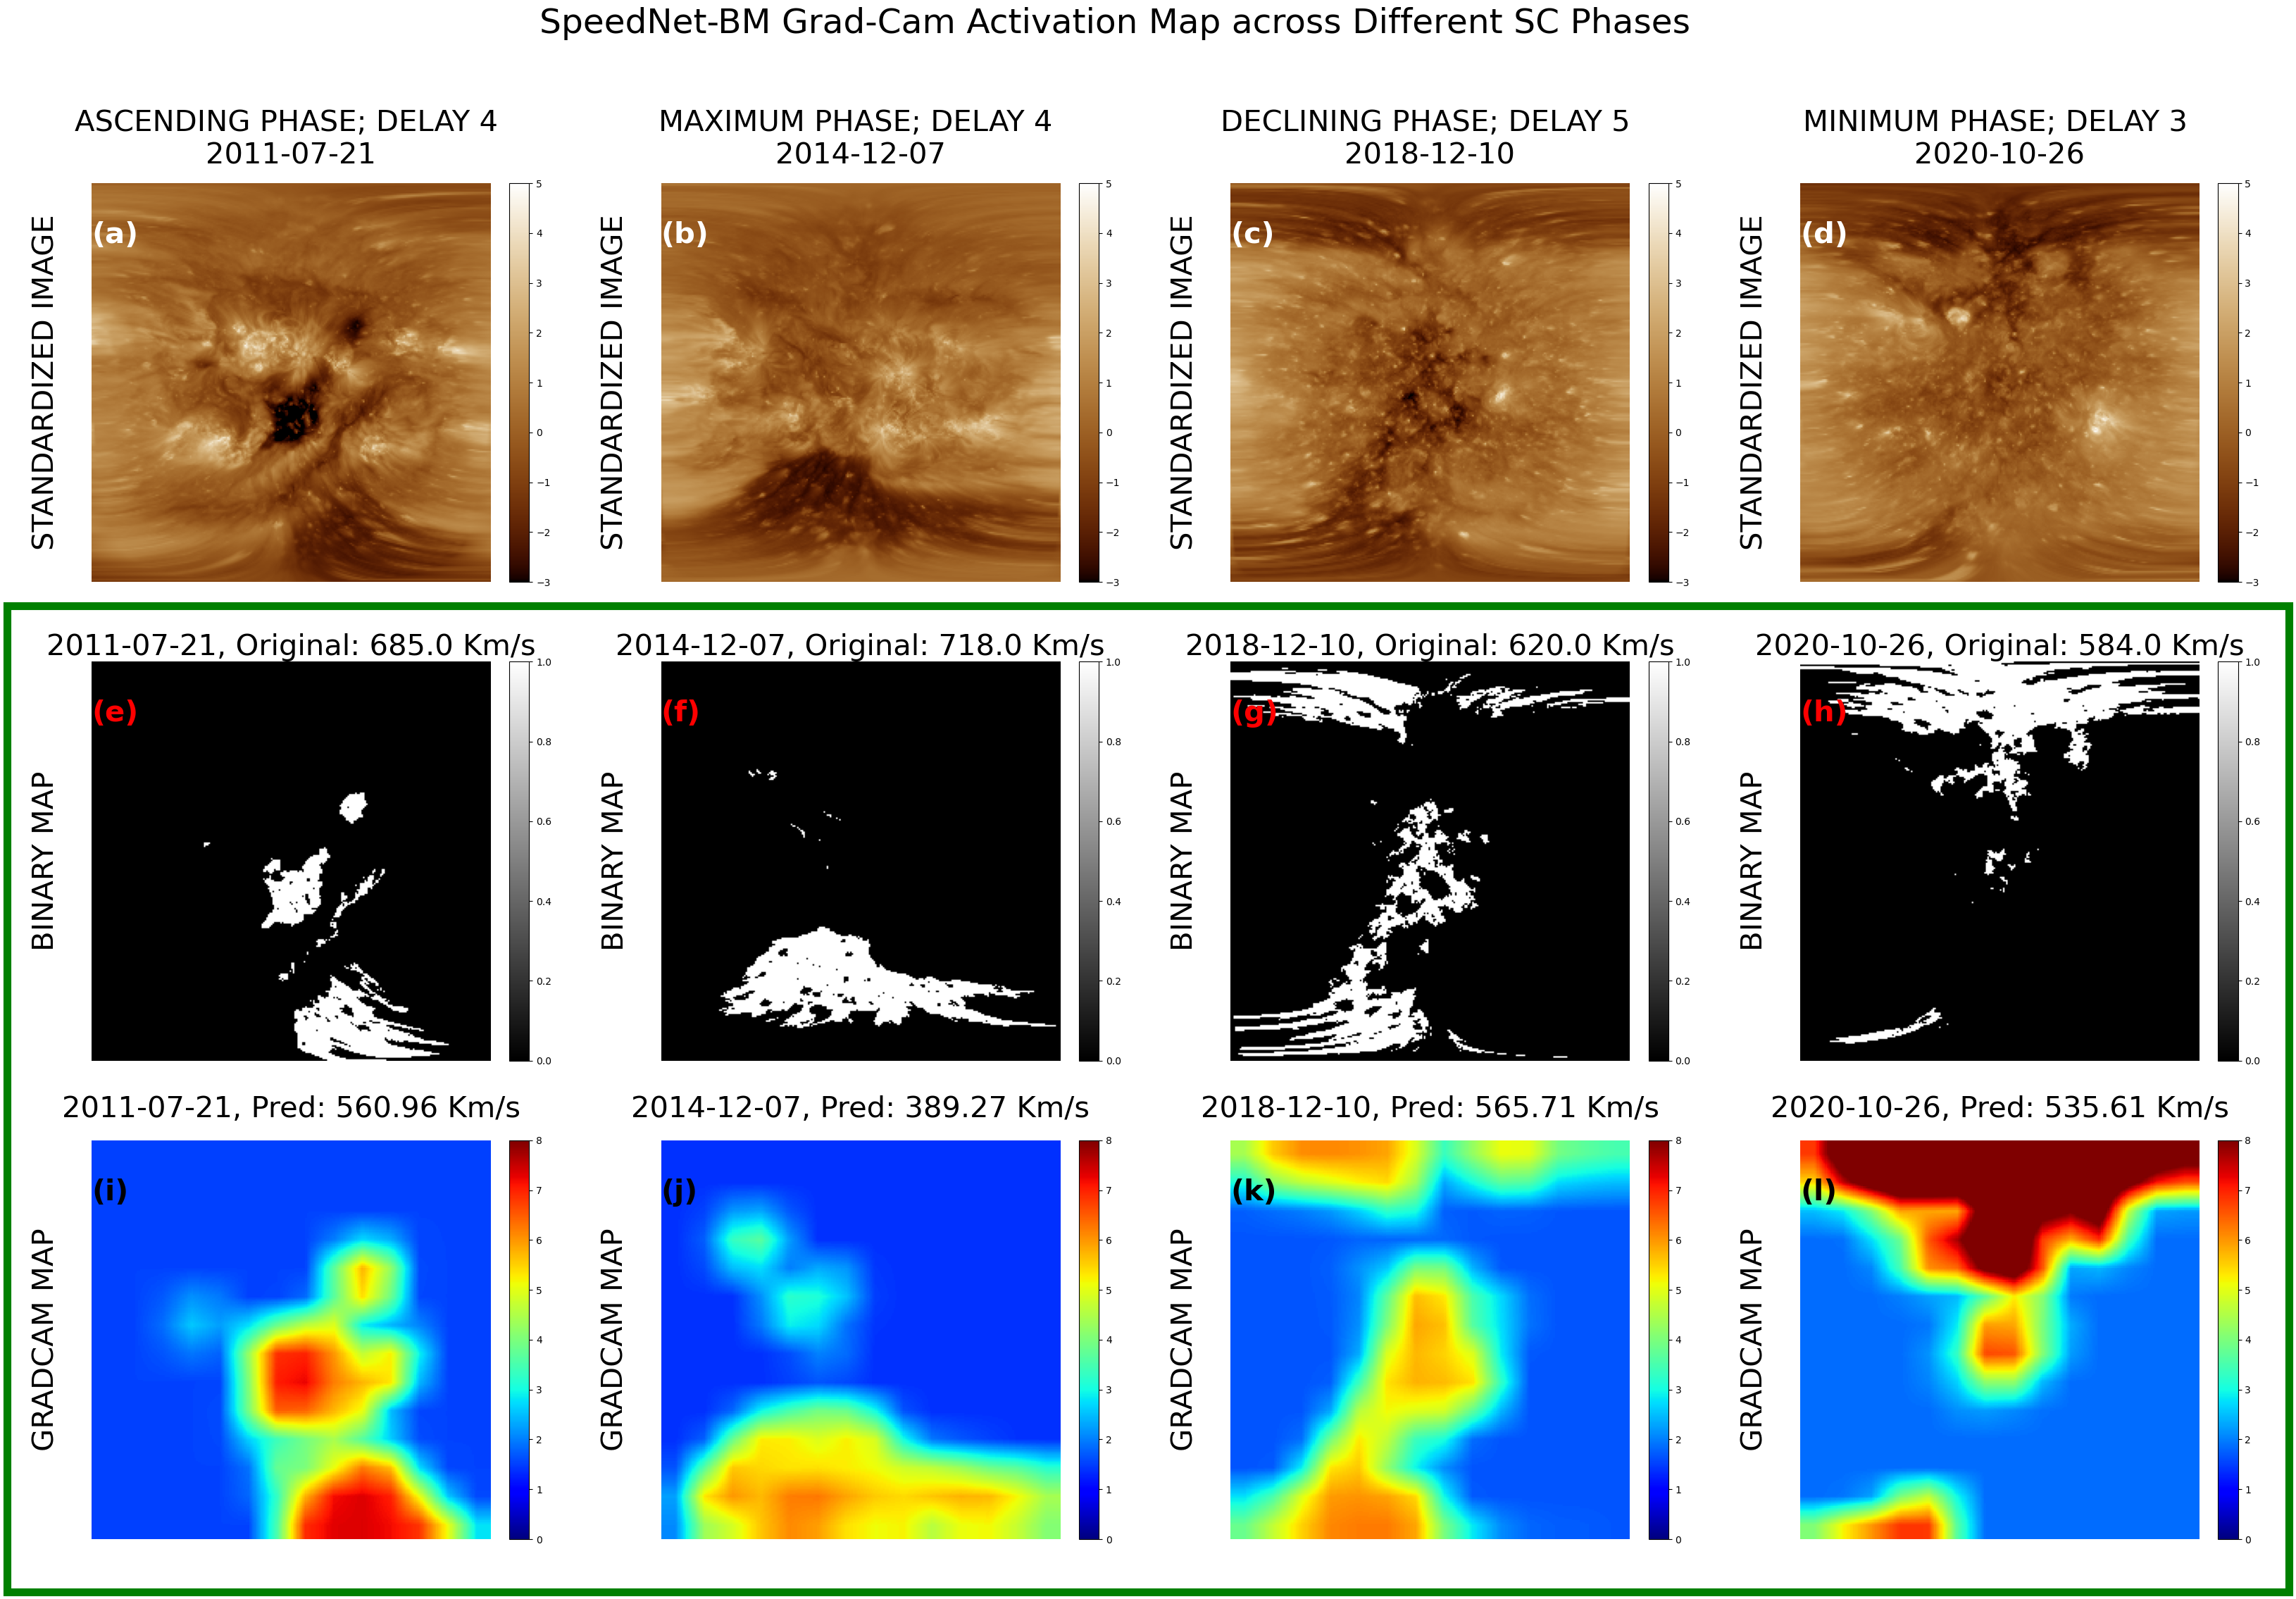

In [18]:
fig, axs = plt.subplots(3, 4, figsize=(40, 25))
fig.suptitle(f"SpeedNet-BM Grad-Cam Activation Map across Different SC Phases", fontsize=35)

plt.style.use("default")

# ASCENDING PHASE
ascend_standardized = axs[0, 0].imshow(ascending_standardized_set[1][:,:,0], cmap='sdoaia193', vmin=-3, vmax=5) 
fig.colorbar(ascend_standardized ,ax=axs[0, 0], fraction=0.05, pad=0.04)
axs[0, 0].set_title(f'ASCENDING PHASE; DELAY {ascending_num_delay+1} \n{pd.to_datetime(list(ascending_Test_timeseries_date)[ascending_indices_rand[1]+(ascending_num_delay+1)]).date[0]}', fontsize=30, pad=20)
axs[0, 0].set_xlabel(f'Longitude [deg]')
axs[0, 0].set_ylabel(f'Latitude [deg]')
axs[0, 0].axis('off')
axs[0, 0].set_label('Intensity')
axs[0, 0].text(-0.15, 0.5, f'STANDARDIZED IMAGE', fontsize=30, rotation=90, transform=axs[0, 0].transAxes, va='center')
axs[0, 0].text(0, 0.85, '(a)', fontsize=30, fontweight='bold', transform=axs[0, 0].transAxes, color='white')

    
# MAXIMUM PHASE 
maximum_standardized = axs[0, 1].imshow(maximum_standardized_set[1][:,:,0], cmap='sdoaia193', vmin=-3, vmax=5) 
fig.colorbar(maximum_standardized , ax=axs[0, 1], fraction=0.05, pad=0.04)
axs[0, 1].set_title(f'MAXIMUM PHASE; DELAY {maximum_num_delay+1} \n{pd.to_datetime(list(maximum_Test_timeseries_date)[Maximum_indices_rand[1]+(maximum_num_delay+1)]).date[0]}', fontsize=30, pad=20)
axs[0, 1].set_xlabel(f'Longitude [deg]')
axs[0, 1].set_ylabel(f'Latitude [deg]')
axs[0, 1].axis('off')
axs[0, 1].set_label('Intensity')
axs[0, 1].text(-0.15, 0.5, f'STANDARDIZED IMAGE', fontsize=30, rotation=90, transform=axs[0, 1].transAxes, va='center')
axs[0, 1].text(0, 0.85, '(b)', fontsize=30, fontweight='bold', transform=axs[0, 1].transAxes, color='white')

# DECLINING PHASE
declining_standardized = axs[0, 2].imshow(declining_standardized_set[1][:,:,0], cmap='sdoaia193', vmin=-3, vmax=5) 
fig.colorbar(declining_standardized ,ax=axs[0, 2], fraction=0.05, pad=0.04)
axs[0, 2].set_title(f'DECLINING PHASE; DELAY {decline_num_delay+1} \n{pd.to_datetime(list(declining_Test_timeseries_date)[declining_indices_rand[1]+(decline_num_delay+1)]).date[0]}', fontsize=30, pad=20)
axs[0, 2].set_xlabel(f'Longitude [deg]')
axs[0, 2].set_ylabel(f'Latitude [deg]')
axs[0, 2].axis('off')
axs[0, 2].set_label('Intensity')
axs[0, 2].text(-0.15, 0.5, f'STANDARDIZED IMAGE', fontsize=30, rotation=90, transform=axs[0, 2].transAxes, va='center')
axs[0, 2].text(0, 0.85, '(c)', fontsize=30, fontweight='bold', transform=axs[0, 2].transAxes, color='white')

# MINIMUM PHASE
minimum_standardized = axs[0, 3].imshow(minimum_standardized_set[1][:,:,0], cmap='sdoaia193', vmin=-3, vmax=5) 
fig.colorbar(minimum_standardized ,ax=axs[0, 3], fraction=0.05, pad=0.04)
axs[0, 3].set_title(f'MINIMUM PHASE; DELAY {Minimum_num_delay+1} \n{pd.to_datetime(list(Minimum_Test_timeseries_date)[Minimum_indices_rand[1]+(Minimum_num_delay+1)]).date[0]}', fontsize=30, pad=20)
axs[0, 3].set_xlabel(f'Longitude [deg]')
axs[0, 3].set_ylabel(f'Latitude [deg]')
axs[0, 3].axis('off')
axs[0, 3].set_label('Intensity')
axs[0, 3].text(-0.15, 0.5, f'STANDARDIZED IMAGE', fontsize=30, rotation=90, transform=axs[0, 3].transAxes, va='center')
axs[0, 3].text(0, 0.85, '(d)', fontsize=30, fontweight='bold', transform=axs[0, 3].transAxes, color='white')

### BINARY MAP

# ASCENDING PHASE
ascend_binary = axs[1, 0].imshow(ascending_random_selection[1], cmap='gray') 
fig.colorbar(ascend_binary ,ax=axs[1, 0], fraction=0.05, pad=0.04)
axs[1, 0].set_title(f'{pd.to_datetime(list(ascending_Test_timeseries_date)[ascending_indices_rand[1]+(ascending_num_delay+1)]).date[0]}, Original: {tf.squeeze(ascending_orig_value[1])} Km/s', fontsize=30)
axs[1, 0].set_xlabel(f'Longitude [deg]')
axs[1, 0].set_ylabel(f'Latitude [deg]')
axs[1, 0].axis('off')
axs[1, 0].set_label('Intensity')
axs[1, 0].text(-0.15, 0.5, f'BINARY MAP', fontsize=30, rotation=90, transform=axs[1, 0].transAxes, va='center')
axs[1, 0].text(0, 0.85, '(e)', fontsize=30, fontweight='bold', transform=axs[1, 0].transAxes, color='red')
     
     
#MAXIMUM PHASE 
maximum_binary = axs[1, 1].imshow(maximum_random_selection[1], cmap='gray') 
fig.colorbar(maximum_binary ,ax=axs[1, 1], fraction=0.05, pad=0.04)
axs[1, 1].set_title(f'{pd.to_datetime(list(maximum_Test_timeseries_date)[Maximum_indices_rand[1]+(maximum_num_delay+1)]).date[0]}, Original: {tf.squeeze(maximum_orig_value[1])} Km/s', fontsize=30)
axs[1, 1].set_xlabel(f'Longitude [deg]')
axs[1, 1].set_ylabel(f'Latitude [deg]')
axs[1, 1].axis('off')
axs[1, 1].set_label('Intensity')
axs[1, 1].text(-0.15, 0.5, f'BINARY MAP', fontsize=30, rotation=90, transform=axs[1, 1].transAxes, va='center')
axs[1, 1].text(0, 0.85, '(f)', fontsize=30, fontweight='bold', transform=axs[1, 1].transAxes, color='red')
   
    
#DECLINING PHASE 
decline_binary = axs[1, 2].imshow(declining_random_selection[1], cmap='gray') 
fig.colorbar(decline_binary ,ax=axs[1, 2], fraction=0.05, pad=0.04)
axs[1, 2].set_title(f'{pd.to_datetime(list(declining_Test_timeseries_date)[declining_indices_rand[1]+(decline_num_delay+1)]).date[0]}, Original: {tf.squeeze(declining_orig_value[1])} Km/s', fontsize=30)
axs[1, 2].set_xlabel(f'Longitude [deg]')
axs[1, 2].set_ylabel(f'Latitude [deg]')
axs[1, 2].axis('off')
axs[1, 2].set_label('Intensity')
axs[1, 2].text(-0.15, 0.5, f'BINARY MAP', fontsize=30, rotation=90, transform=axs[1, 2].transAxes, va='center')
axs[1, 2].text(0, 0.85, '(g)', fontsize=30, fontweight='bold', transform=axs[1, 2].transAxes, color='red')
    

#MINIMUM PHASE 
minimum_binary =  axs[1, 3].imshow(minimum_random_selection[1], cmap='gray') 
fig.colorbar(minimum_binary ,ax= axs[1, 3], fraction=0.05, pad=0.04)
axs[1, 3].set_title(f'{pd.to_datetime(list(Minimum_Test_timeseries_date)[Minimum_indices_rand[1]+(Minimum_num_delay+1)]).date[0]}, Original: {tf.squeeze(minimum_orig_value[1])} Km/s', fontsize=30)
axs[1, 3].set_xlabel(f'Longitude [deg]')
axs[1, 3].set_ylabel(f'Latitude [deg]')
axs[1, 3].axis('off')
axs[1, 3].set_label('Intensity')
axs[1, 3].text(-0.15, 0.5, f'BINARY MAP', fontsize=30, rotation=90, transform= axs[1, 3].transAxes, va='center')
axs[1, 3].text(0, 0.85, '(h)', fontsize=30, fontweight='bold', transform=axs[1, 3].transAxes, color='red')

    
### Grad-Cam HEAT MAP

#ASCENDING PHASE
ascend_img_cam, ascend_value = gradcamm(ascending_random_selection[1].reshape(1,256, 256, 1), best_model_ascending)
ascending_grad_cam = axs[2, 0].matshow(ascend_img_cam, cmap='jet', vmin=0, vmax=8) #axs[1, i].matshow(ascend_img_cam+(random_selection[i].reshape(1,256, 256, 1))[0,:,:,0])
fig.colorbar(ascending_grad_cam ,ax=axs[2, 0], fraction=0.05, pad=0.04)
axs[2, 0].axis('off') 
axs[2, 0].set_label('Intensity')
axs[2, 0].set_title(f'{pd.to_datetime(list(ascending_Test_timeseries_date)[ascending_indices_rand[1]+(ascending_num_delay+1)]).date[0]}, Pred: {tf.squeeze(ascend_value):.2f} Km/s', fontsize=30)
axs[2, 0].text(-0.15, 0.5, f'GRADCAM MAP', fontsize=30, rotation=90, transform=axs[2, 0].transAxes, va='center')
axs[2, 0].text(0, 0.85, '(i)', fontsize=30, fontweight='bold', transform=axs[2, 0].transAxes, color='black')
  

#MAXIMUM PHASE
maximum_img_cam, maximum_value = gradcamm(maximum_random_selection[1].reshape(1,256, 256, 1), best_model_maximum)
maximum_grad_cam = axs[2, 1].matshow(maximum_img_cam, cmap='jet', vmin=0, vmax=8) 
fig.colorbar(maximum_grad_cam ,ax=axs[2, 1], fraction=0.05, pad=0.04)
axs[2, 1].axis('off') 
axs[2, 1].set_label('Intensity')
axs[2, 1].set_title(f'{pd.to_datetime(list(maximum_Test_timeseries_date)[Maximum_indices_rand[1]+(maximum_num_delay+1)]).date[0]}, Pred: {tf.squeeze(maximum_value):.2f} Km/s', fontsize=30)
axs[2, 1].text(-0.15, 0.5, f'GRADCAM MAP', fontsize=30, rotation=90, transform=axs[2, 1].transAxes, va='center')
axs[2, 1].text(0, 0.85, '(j)', fontsize=30, fontweight='bold', transform=axs[2, 1].transAxes, color='black')
    
#DECLINING PHASE
decline_img_cam, decline_value = gradcamm(declining_random_selection[1].reshape(1,256, 256, 1), best_model_declining)
declining_grad_cam = axs[2, 2].matshow(decline_img_cam, cmap='jet', vmin=0, vmax=8)
fig.colorbar(declining_grad_cam ,ax=axs[2, 2], fraction=0.05, pad=0.04)
axs[2, 2].axis('off') 
axs[2, 2].set_label('Intensity')
axs[2, 2].set_title(f'{pd.to_datetime(list(declining_Test_timeseries_date)[declining_indices_rand[1]+(decline_num_delay+1)]).date[0]}, Pred: {tf.squeeze(decline_value):.2f} Km/s', fontsize=30)
axs[2, 2].text(-0.15, 0.5, f'GRADCAM MAP', fontsize=30, rotation=90, transform=axs[2, 2].transAxes, va='center')
axs[2, 2].text(0, 0.85, '(k)', fontsize=30, fontweight='bold', transform=axs[2, 2].transAxes, color='black')

#MINIMUM PHASE
minimum_img_cam, minimum_value = gradcamm(minimum_random_selection[1].reshape(1,256, 256, 1), best_model_Minimum)
minimum_grad_cam = axs[2, 3].matshow(minimum_img_cam, cmap='jet', vmin=0, vmax=8) 
fig.colorbar(minimum_grad_cam ,ax=axs[2, 3], fraction=0.05, pad=0.04)
axs[2, 3].axis('off') 
axs[2, 3].set_label('Intensity')
axs[2, 3].set_title(f'{pd.to_datetime(list(Minimum_Test_timeseries_date)[Minimum_indices_rand[1]+(Minimum_num_delay+1)]).date[0]}, Pred: {tf.squeeze(minimum_value):.2f} Km/s', fontsize=30)
axs[2, 3].text(-0.15, 0.5, f'GRADCAM MAP', fontsize=30, rotation=90, transform=axs[2, 3].transAxes, va='center')
axs[2, 3].text(0, 0.85, '(l)', fontsize=30, fontweight='bold', transform=axs[2, 3].transAxes, color='black')
   
col_left = axs[2, 0].get_position().x0      # Left edge of the last column   
row_bottom = axs[2, 0].get_position().y0  # Bottom of the last column
# Create the rectangle with the adjusted boundaries
rect = patches.Rectangle(
    (col_left - 0.03, row_bottom - 0.03),      # Bottom-left corner in normalized figure coordinates
    0.81,          # Width
    0.56,      # Height
    linewidth=8,
    edgecolor='green',
    facecolor='none',
    transform=fig.transFigure,
)

# Add the rectangle to the figure
fig.patches.append(rect)
    
# plt.tight_layout()
# plt.subplots_adjust(top=0.95, hspace=0.3)
plt.savefig(f"Summarized_bin_windnet_gradcam_a.png")
plt.show()

### FULL SC PERIOD

In [19]:
n_steps = 1
fold_index = 1
full_period_num_delay = 3
path = "/home/joseph/DL/DATASET"
train_start_date = "2010-05-13"
train_end_date = "2018-12-31"
test_start_date = "2019-01-01"
test_end_date = "2019-12-31"
img_train_path = "/home/joseph/DL/DATASET/FULL_CYCLE_BINARY/Train"
img_test_path = "/home/joseph/DL/DATASET/FULL_CYCLE_BINARY/Test"

# Prepare the Timeseries data 
df, velocity_train, velocity_test, std_velocity_test, train_speed_dates, test_speed_dates, full_icme_list = SpeedNet_model_prep.load_df(path, train_start_date,
                                                                                                                                        train_end_date, test_start_date, 
                                                                                                                                        test_end_date)

# Returns the Solar Map Dates (Timestamps) after ICME FILTERATION
map_train_non_icme_date, map_test_non_icme_date = SpeedNet_model_prep.non_icme_Image_date(img_train_path, img_test_path, full_icme_list)

# ADAPTS THE FILTERED SW AND MAP DATES BY RETURNING THE NEW INDEX 
Speed_train_indices, Speed_test_indices, solar_image_train_indices, solar_image_test_indices = SpeedNet_model_prep.time_adaptation_delay_prep(train_start_date, train_end_date,
                                                                                                                                               test_start_date, test_end_date,
                                                                                                                                               train_speed_dates, test_speed_dates,
                                                                                                                                               map_train_non_icme_date, map_test_non_icme_date)

# Preparing the Training Dates BY ADAPTING WITH THE TIME DELAY
full_period_Train_image_cnn_date, full_period_Train_timeseries_date, full_period_Train_output_timeseries_date = SpeedNet_model_prep.match_data_prep(full_period_num_delay,
                                                                                                                                                    n_steps, map_train_non_icme_date,
                                                                                                                                                    train_speed_dates, 
                                                                                                                                                    solar_image_train_indices, Speed_train_indices)    

# Preparing the Testing Dates BY ADAPTING WITH THE TIME DELAY
full_period_Test_image_cnn_date, full_period_Test_timeseries_date, full_period_Test_output_timeseries_date = SpeedNet_model_prep.match_data_prep(full_period_num_delay,
                                                                                                                                                 n_steps, map_test_non_icme_date,
                                                                                                                                                 test_speed_dates, 
                                                                                                                                                 solar_image_test_indices, Speed_test_indices)

# Using the New SW datetime (Prepare the timeseries (Train, Test, Test:Timestamps))
full_period_train_velocity_out, full_period_test_velocity_out, full_period_test_timestamps_output = SpeedNet_model_prep.filter_output(df, full_period_Train_output_timeseries_date, full_period_Test_output_timeseries_date)

# Using the New Map datetime (Prepare the MAPS (Train, Test))
full_period_train_images, full_period_test_images =  SpeedNet_model_prep.train_test_set(img_train_path, img_test_path, full_period_Train_image_cnn_date,full_period_Test_image_cnn_date)

# Load the Pretrained Model
best_model_full_period = load_model(f"/home/joseph/DL/SpeedNet-BM/FULL_CYCLE/best_model_for_fold_{fold_index}_timestep_{n_steps}_and_delay_{full_period_num_delay}.keras")

# Pretrained Model Prediction
best_pred_full_period = best_model_full_period.predict(full_period_test_images)

# Save the Prediction together with the Observation as CSV File
full_cycle_save_to_csv = save_data_csv(full_period_test_timestamps_output, full_period_test_velocity_out, best_pred_full_period, "FULL_CYCLE", fold_index, full_period_num_delay, n_steps=1)

# Load the corresponding Standardized Map (For Visualization Purpose)
# Save the File as .npy (numpy Array)
full_period_stand_img_file_path = "/home/joseph/DL/DATASET/FULL_CYCLE_CHANNEL_256/Test"
full_period_save_original_standardized_image = real_test_data(full_period_stand_img_file_path, fold_index, full_period_num_delay, "FULL_CYCLE", full_period_Test_image_cnn_date)



## HSS Period

In [21]:
### Obtain the Peak 
full_period_max = np.argmax(full_period_test_velocity_out)

# Two days before the HSS peak and two days after the peak
HSS_full_period_indices_rand = [full_period_max-2, full_period_max-1, full_period_max, full_period_max+1, full_period_max+2]

# Four days before the HSS peak and Four days after the peak
longer_HSS_full_period_indices_rand = [full_period_max-4, full_period_max-3, full_period_max-2, full_period_max-1, full_period_max, full_period_max+1, full_period_max+2, full_period_max+3, full_period_max+4]



In [22]:
### EUV-MAP during the Period (Two days before/after)
HSS_full_period_random_selection = full_period_test_images[HSS_full_period_indices_rand]

### BM-MAP during the Period (Two days before/after)
full_period_loaded_array = np.load(f'FULL_CYCLE_test_fold_1_and_delay_4.npy')

HSS_full_period_standardized_set = full_period_loaded_array[HSS_full_period_indices_rand]


### Observed Solar wind speed during the Period (Two days before/after)
HSS_full_period_orig_value = full_period_test_velocity_out[HSS_full_period_indices_rand]
### DATE during the Period (Two days before/after)
HSS_full_period_test_plot_date = pd.to_datetime(list(full_period_Test_timeseries_date)[HSS_full_period_indices_rand[1]]).date[0]


### BM-MAP during the Period (Four days before/after)
Longer_HSS_full_period_random_selection = full_period_test_images[longer_HSS_full_period_indices_rand]

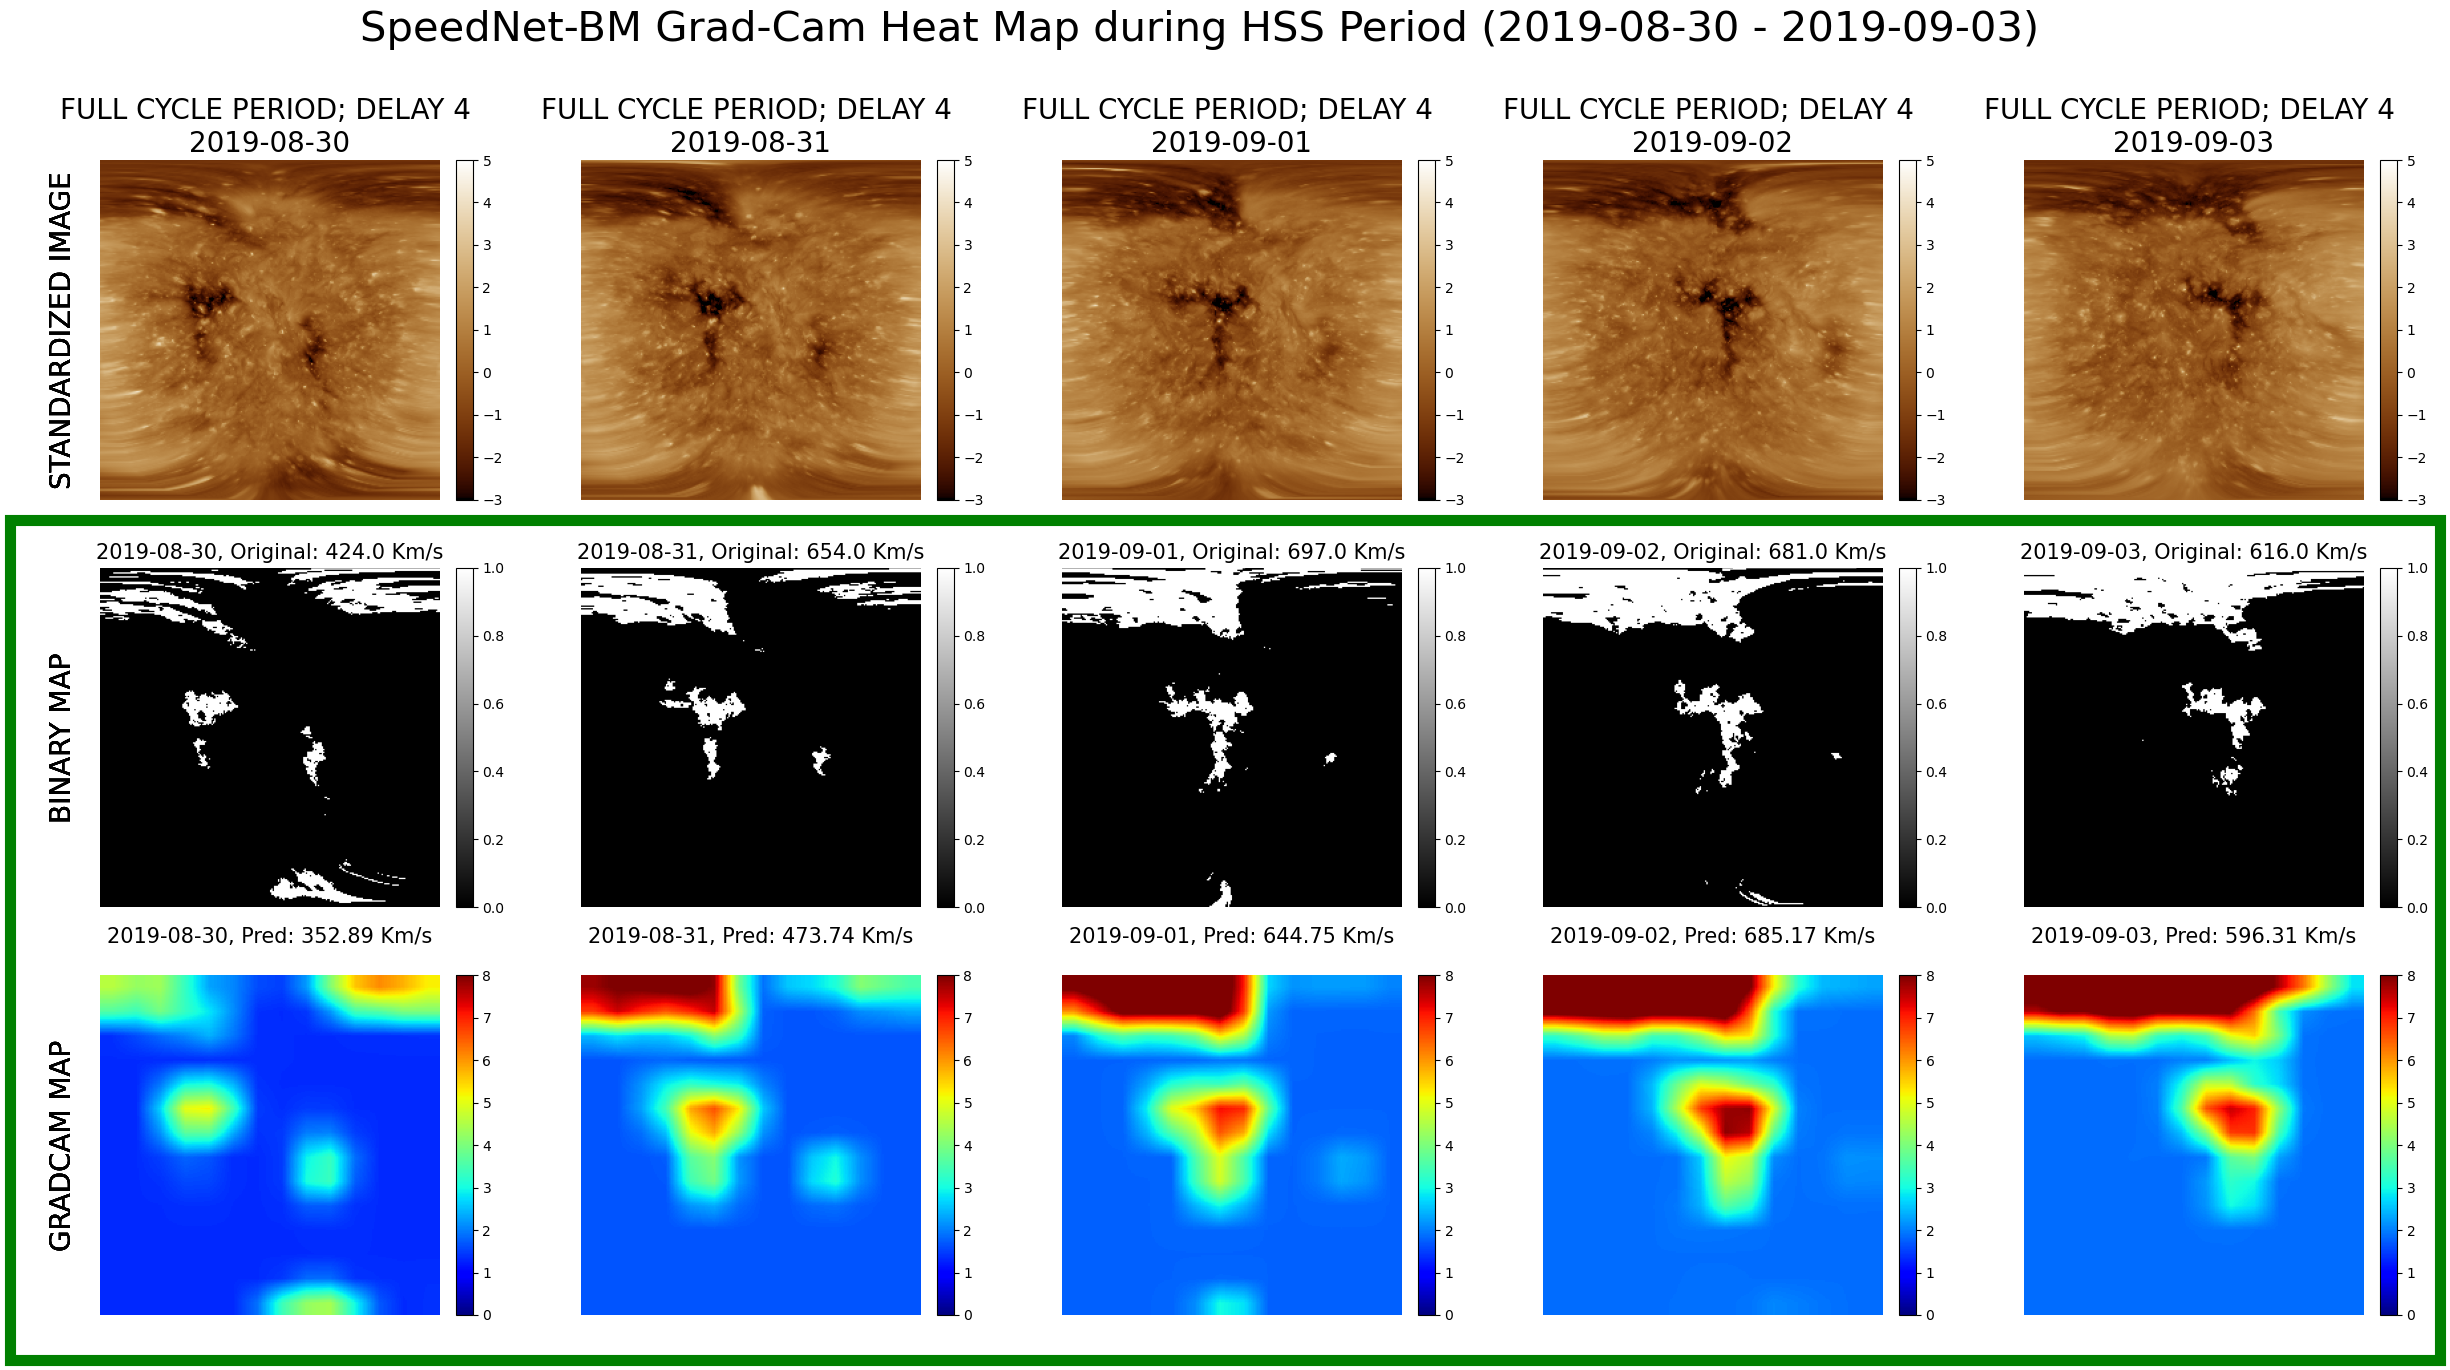

In [23]:
fig, axs = plt.subplots(3, 5, figsize=(30, 15))
fig.suptitle(f"SpeedNet-BM Grad-Cam Heat Map during HSS Period ({pd.to_datetime(list(full_period_Test_timeseries_date)[HSS_full_period_indices_rand[0]+(full_period_num_delay+1)]).strftime('%Y-%m-%d')[0]} - {pd.to_datetime(list(full_period_Test_timeseries_date)[HSS_full_period_indices_rand[-1]+(full_period_num_delay+1)]).strftime('%Y-%m-%d')[0]})" , fontsize=30)

plt.style.use("default")

for i in range(len(HSS_full_period_indices_rand)):
    # FULL CYCLE PERIOD
    HSS_full_period_standardized = axs[0, i].imshow(HSS_full_period_standardized_set[i][:,:,0], cmap='sdoaia193', vmin=-3, vmax=5) 
    fig.colorbar(HSS_full_period_standardized ,ax=axs[0, i], fraction=0.05, pad=0.04)
    axs[0, i].set_title(f'FULL CYCLE PERIOD; DELAY {full_period_num_delay+1} \n{pd.to_datetime(list(full_period_Test_timeseries_date)[HSS_full_period_indices_rand[i]+(full_period_num_delay+1)]).date[0]}', fontsize=20)
    axs[0, i].set_xlabel(f'Longitude [deg]')
    axs[0, i].set_ylabel(f'Latitude [deg]')
    axs[0, i].axis('off')
    axs[0, i].set_label('Intensity')
    axs[0, 0].text(-0.15, 0.5, f'STANDARDIZED IMAGE', fontsize=20, rotation=90, transform=axs[0, 0].transAxes, va='center')
    
    HSS_full_period_binary = axs[1, i].imshow(HSS_full_period_random_selection[i], cmap='gray') 
    fig.colorbar(HSS_full_period_binary ,ax=axs[1, i], fraction=0.05, pad=0.04)
    axs[1, i].set_title(f'{pd.to_datetime(list(full_period_Test_timeseries_date)[HSS_full_period_indices_rand[i]+(full_period_num_delay+1)]).date[0]}, Original: {tf.squeeze(HSS_full_period_orig_value[i])} Km/s', fontsize=15)
    axs[1, i].set_xlabel(f'Longitude [deg]')
    axs[1, i].set_ylabel(f'Latitude [deg]')
    axs[1, i].axis('off')
    axs[1, i].set_label('Intensity')
    axs[1, 0].text(-0.15, 0.5, f'BINARY MAP', fontsize=20, rotation=90, transform=axs[1, 0].transAxes, va='center')
    
    HSS_full_period_img_cam, HSS_full_period_value = gradcamm(HSS_full_period_random_selection[i].reshape(1,256, 256, 1), best_model_full_period)
    HSS_full_period_grad_cam = axs[2, i].matshow(HSS_full_period_img_cam, cmap='jet', vmin=0, vmax=8)
    fig.colorbar(HSS_full_period_grad_cam ,ax=axs[2, i], fraction=0.05, pad=0.04)
    axs[2, i].axis('off') 
    axs[2, i].set_label('Intensity')
    axs[2, i].set_title(f'{pd.to_datetime(list(full_period_Test_timeseries_date)[HSS_full_period_indices_rand[i]+(full_period_num_delay+1)]).date[0]}, Pred: {tf.squeeze(HSS_full_period_value):.2f} Km/s', fontsize=15)
    axs[2, 0].text(-0.15, 0.5, f'GRADCAM MAP', fontsize=20, rotation=90, transform=axs[2, 0].transAxes, va='center')
    
    col_left = axs[2, 0].get_position().x0      # Left edge of the last column   
    row_bottom = axs[2, 0].get_position().y0  # Bottom of the last column
    # Create the rectangle with the adjusted boundaries
    rect = patches.Rectangle(
        (col_left - 0.03, row_bottom - 0.03),      # Bottom-left corner in normalized figure coordinates
        0.81,          # Width
        0.56,      # Height
        linewidth=8,
        edgecolor='green',
        facecolor='none',
        transform=fig.transFigure,
    )

# Add the rectangle to the figure
fig.patches.append(rect)
    
    
# plt.subplots_adjust(top=0.95) 
plt.savefig(f"HSS_BINWINDNET_ACROSS_Full_sc.png")
plt.show()

### PLOT THE TIMESERIES DATA

In [24]:
Ascending_case_2 = pd.read_csv("ASCENDING_PHASE_3_and_delay_4.csv")
Ascending_case_2["date"]=pd.to_datetime(Ascending_case_2["date"], format="mixed")
Ascending_case_2.set_index(Ascending_case_2["date"], inplace=True)
Ascending_case_2.head()

date  test_original  test_predicted
date                                                
2011-07-12 2011-07-12          681.0       572.30880
2011-07-13 2011-07-13          538.0       404.09042
2011-07-14 2011-07-14          493.0       397.55478
2011-07-15 2011-07-15            NaN             NaN
2011-07-16 2011-07-16            NaN             NaN

In [25]:
Maximum_case_2 = pd.read_csv("MAXIMUM_PHASE_1_and_delay_4.csv")
Maximum_case_2["date"]=pd.to_datetime(Maximum_case_2["date"], format="mixed")
Maximum_case_2.set_index(Maximum_case_2["date"], inplace=True)
Maximum_case_2.head()

date  test_original  test_predicted
date                                                
2014-02-27 2014-02-27          377.0       324.43082
2014-02-28 2014-02-28          428.0       330.21158
2014-03-01 2014-03-01          393.0       341.22040
2014-03-02 2014-03-02          372.0       348.89460
2014-03-03 2014-03-03          346.0       362.20370

In [26]:
Declining_case_2 = pd.read_csv("DECLINING_PHASE_1_and_delay_5.csv")
Declining_case_2["date"]=pd.to_datetime(Declining_case_2["date"], format="mixed")
Declining_case_2.set_index(Declining_case_2["date"], inplace=True)
Declining_case_2.head()

date  test_original  test_predicted
date                                                
2018-01-06 2018-01-06          305.0       323.80515
2018-01-07 2018-01-07          289.0       371.29697
2018-01-08 2018-01-08          387.0       366.05472
2018-01-09 2018-01-09          503.0       389.72952
2018-01-10 2018-01-10          440.0       395.48914

In [27]:
Minimum_case_2 = pd.read_csv("MINIMUM_PHASE_4_and_delay_3.csv")
Minimum_case_2["date"]=pd.to_datetime(Minimum_case_2["date"], format="mixed")
Minimum_case_2.set_index(Minimum_case_2["date"], inplace=True)
Minimum_case_2.head()

date  test_original  test_predicted
date                                                
2020-05-30 2020-05-30          365.0       395.84167
2020-05-31 2020-05-31          386.0       380.16850
2020-06-01 2020-06-01          378.0       369.54895
2020-06-02 2020-06-02          343.0       333.68738
2020-06-03 2020-06-03          326.0       359.37128

In [28]:
full_cycle_period_case_2 = pd.read_csv("FULL_CYCLE_1_and_delay_4.csv")
full_cycle_period_case_2["date"]=pd.to_datetime(full_cycle_period_case_2["date"], format="mixed")
full_cycle_period_case_2.set_index(full_cycle_period_case_2["date"], inplace=True)
full_cycle_period_case_2.head()

date  test_original  test_predicted
date                                                
2019-01-05 2019-01-05          487.0       468.56192
2019-01-06 2019-01-06          523.0       461.81012
2019-01-07 2019-01-07          497.0       390.61023
2019-01-08 2019-01-08          431.0       373.05847
2019-01-09 2019-01-09          418.0       358.80340

In [29]:
print("Ascending Phase")
Ascen_best_rmse_case_2, Ascen_rmse_uncertainty_case_2, Ascen_corr_coef_case_2, Ascen_pearson_uncertainty_case_, Ascen_threat_score_case_2 = rmse_corr_metrics(Ascending_case_2["test_original"],Ascending_case_2["test_predicted"])
print("Maximum Phase")
Maxi_best_rmse_case_2, Maxi_rmse_uncertainty_case_2, Maxi_corr_coef_case_2, Maxi_pearson_uncertainty_case_2, Maxi_threat_score_case_2 = rmse_corr_metrics(Maximum_case_2["test_original"], Maximum_case_2["test_predicted"])
print("Declining Phase")
Decl_best_rmse_case_2, Decl_rmse_uncertainty_case_2, Decl_corr_coef_case_2, Decl_pearson_uncertainty_case_2, Decl_threat_score_case_2 = rmse_corr_metrics(Declining_case_2["test_original"], Declining_case_2["test_predicted"])
print("Minimum Phase")
Mini_best_rmse_case_2, Mini_rmse_uncertainty_case_2, Mini_corr_coef_case_2, Mini_pearson_uncertainty_case_2, Mini_threat_score_case_2 = rmse_corr_metrics(Minimum_case_2["test_original"], Minimum_case_2["test_predicted"])
print("Full SC (2019 Only) Phase")
full_best_rmse_2019_case_2, full_rmse_uncertainty_2019_case_2, full_corr_coef_2019_case_2, full_pearson_uncertainty_2019_case_2, full_2019_threat_score_case_2 = rmse_corr_metrics(full_cycle_period_case_2["test_original"], full_cycle_period_case_2["test_predicted"])

Ascending Phase
TP: 3 
FP: 1 
FN: 4
Maximum Phase
TP: 4 
FP: 4 
FN: 9
Declining Phase
TP: 16 
FP: 0 
FN: 13
Minimum Phase
TP: 6 
FP: 2 
FN: 4
Full SC (2019 Only) Phase
TP: 10 
FP: 0 
FN: 10


#### Temporal variation of the timeseries acrooss SC phases

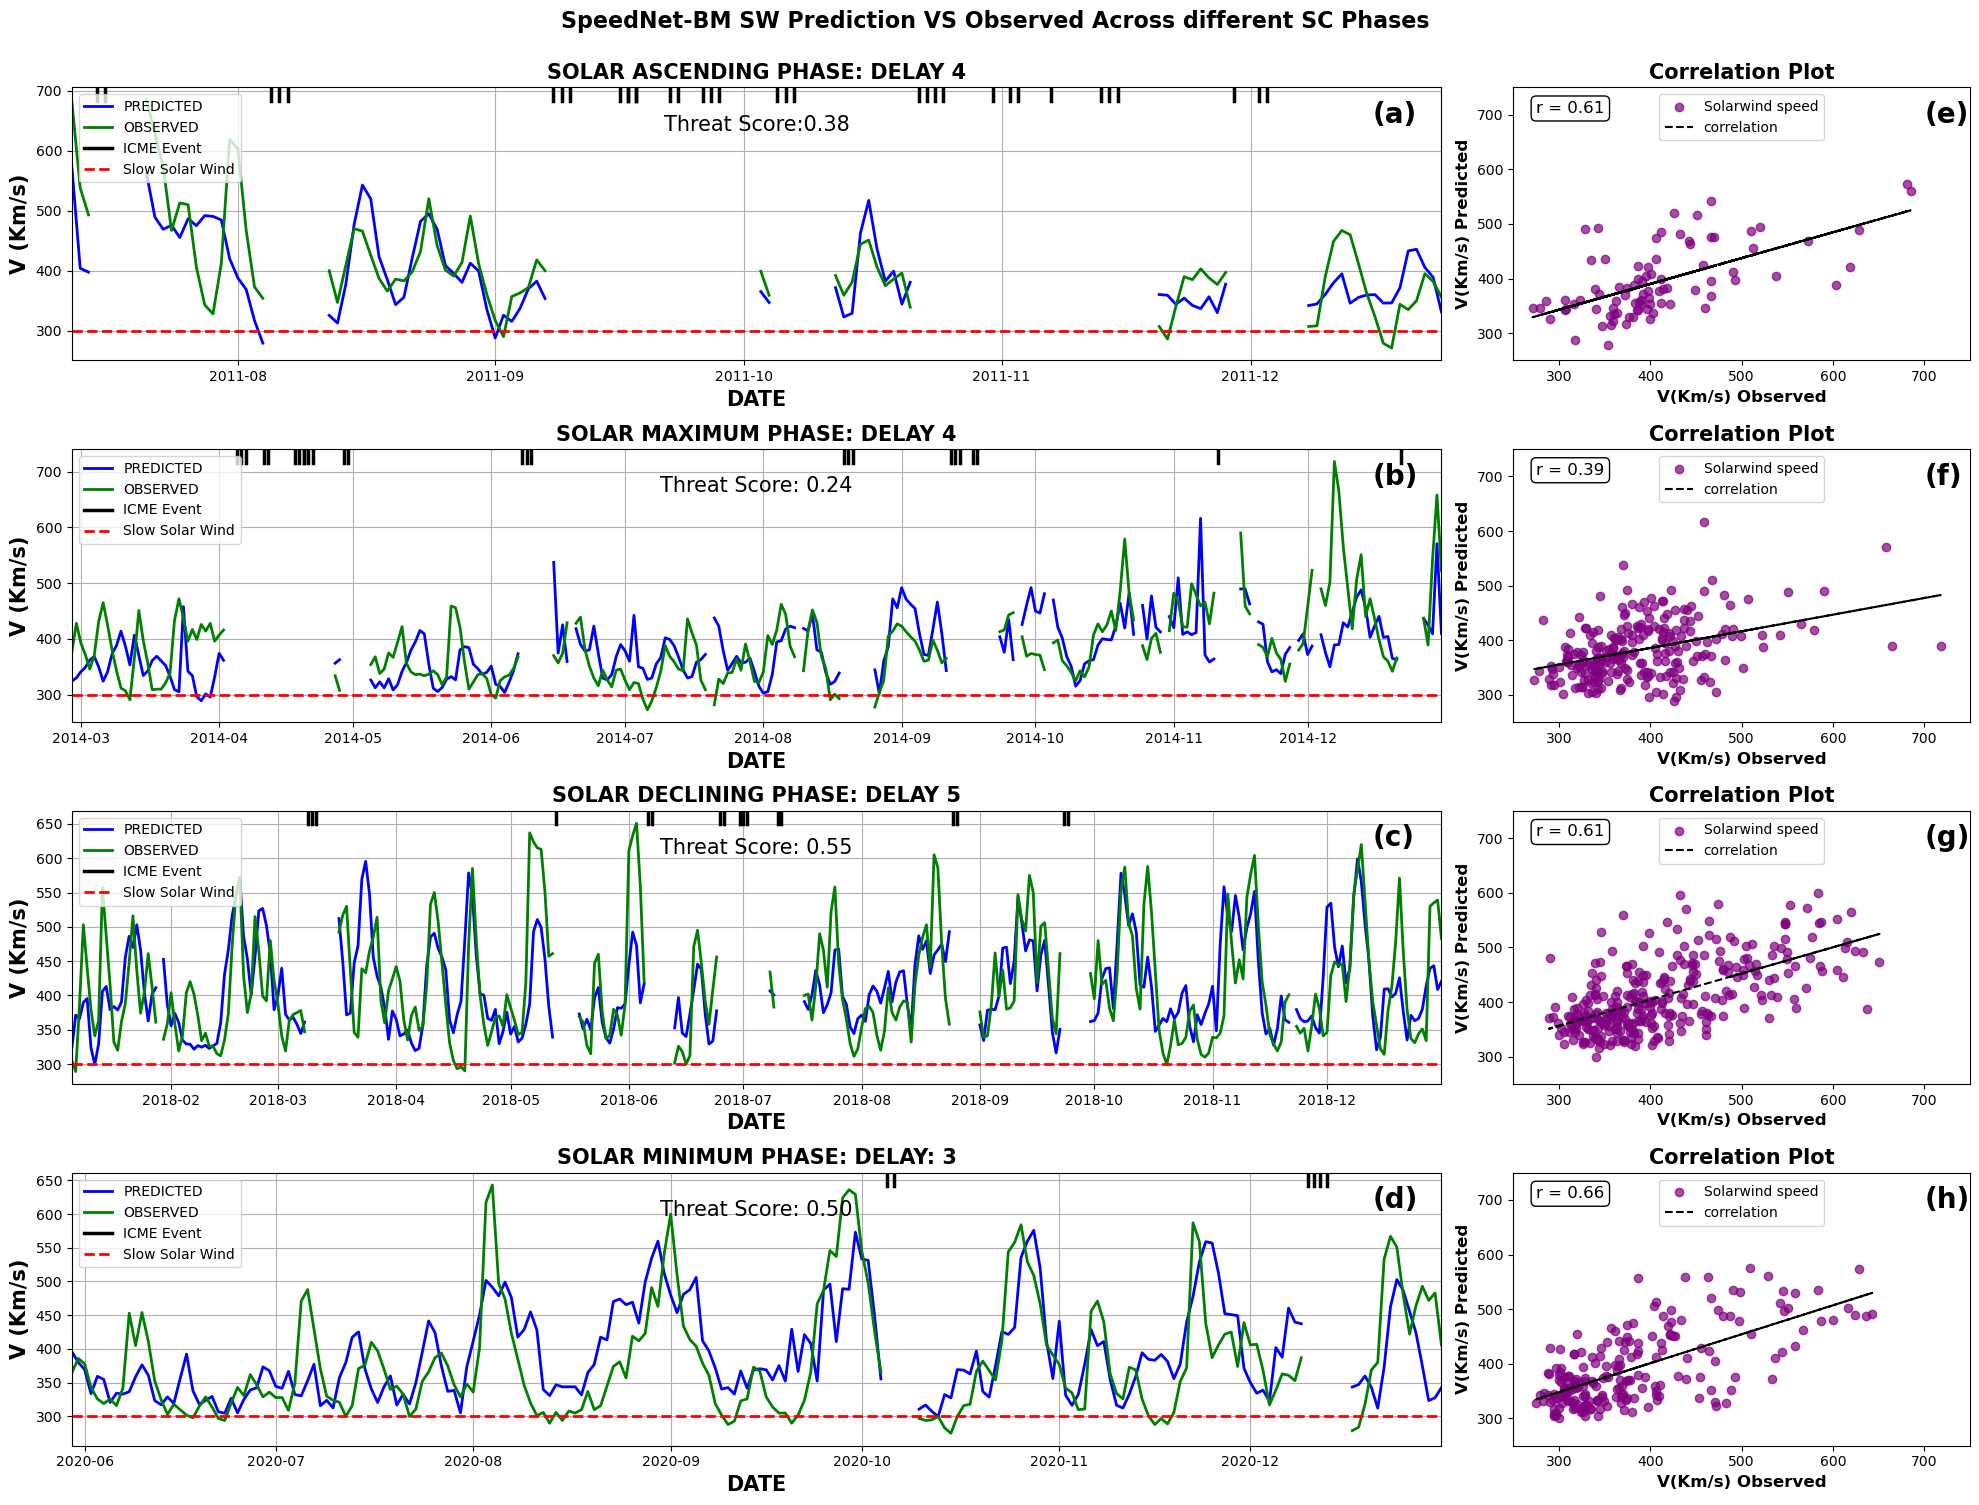

In [30]:
fig, ax = plt.subplots(4, 2, figsize=(20,15), gridspec_kw={'width_ratios': [3, 1]})
# fig.tight_layout(pad=4.0)
plt.plot()
plt.style.use('default')

fig.suptitle(f"SpeedNet-BM SW Prediction VS Observed Across different SC Phases", fontsize = 16, fontweight = "bold", y=1.0);

# ASCENDING PHASE 
ax[0,0].plot(Ascending_case_2['date'],Ascending_case_2["test_predicted"], linestyle='-', color='b', linewidth=2, label= 'PREDICTED')
ax[0,0].plot(Ascending_case_2['date'],Ascending_case_2["test_original"], linestyle='-', color='g', linewidth=2, label= 'OBSERVED')

for i, icme_date in enumerate(full_icme_list):
    ax[0,0].axvline(x=icme_date, color='black', linestyle='-', ymax=1, ymin=0.95, linewidth=2.5, label='ICME Event' if i == 0 else "")
ax[0,0].set_title(f'SOLAR ASCENDING PHASE: DELAY {ascending_num_delay+1}', fontsize = 15, fontweight = "bold")
ax[0,0].set_xlabel('DATE', fontsize = 15, fontweight = "bold")
ax[0,0].set_ylabel('V (Km/s)', fontsize = 15, fontweight = "bold")
ax[0,0].axhline(y=300, color='red', linestyle='--', linewidth=2, label='Slow Solar Wind')
ax[0,0].text(0.5, 0.9, f'Threat Score:{Ascen_threat_score_case_2:.2f}', transform=ax[0,0].transAxes, fontsize=15, va='top', ha='center')
ax[0,0].text(0.95, 0.95, '(a)', transform=ax[0,0].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[0,0].grid("on")
ax[0,0].set_xlim(Ascending_case_2['date'].iloc[0], Ascending_case_2['date'].iloc[-1])
ax[0,0].legend(loc='upper left')

# Correlation plot in the Ascending Phase
ax[0, 1].scatter(Ascending_case_2["test_original"], Ascending_case_2["test_predicted"], alpha=0.7, color='purple', label="Solarwind speed")
# Add correlation line 
obs_cleaned_ascending_case_2, pred_cleaned_ascending_case_2, fitted_y_ascending_case_2, slope_ascending_case_2, intercept_ascending_case_2 = linear_fit(Ascending_case_2)
ax[0, 1].plot(obs_cleaned_ascending_case_2, fitted_y_ascending_case_2, color='black', linestyle='--', label="correlation") 
ax[0, 1].set_title(f"Correlation Plot", fontsize = 15, fontweight = "bold")
ax[0, 1].set_xlabel("V(Km/s) Observed" , fontsize = 12, fontweight = "bold")
ax[0, 1].set_ylabel("V(Km/s) Predicted" , fontsize = 12, fontweight = "bold")
ax[0, 1].text(0.05, 0.95, f"r = {Ascen_corr_coef_case_2:.2f}", transform=ax[0, 1].transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white"))
ax[0,1].text(0.9, 0.95, '(e)', transform=ax[0,1].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[0, 1].set_xlim(250, 750)
ax[0, 1].set_ylim(250, 750)
ax[0, 1].legend(loc='upper center')

# MAXIMUM PHASE

ax[1,0].plot(Maximum_case_2['date'],Maximum_case_2["test_predicted"],  linestyle='-', color='b', linewidth=2, label='PREDICTED')
ax[1,0].plot(Maximum_case_2['date'],Maximum_case_2["test_original"],  linestyle='-', color='g', linewidth=2, label='OBSERVED')
for i, icme_date in enumerate(full_icme_list):
    ax[1,0].axvline(x=icme_date, color='black', linestyle='-', ymax=1, ymin=0.95, linewidth=2.5, label='ICME Event' if i == 0 else "")
ax[1,0].set_title(f'SOLAR MAXIMUM PHASE: DELAY {maximum_num_delay+1}', fontsize = 15, fontweight = "bold")
ax[1,0].set_xlabel('DATE', fontsize = 15, fontweight = "bold")
ax[1,0].set_ylabel('V (Km/s)', fontsize = 15, fontweight = "bold")
ax[1,0].axhline(y=300, color='red', linestyle='--', linewidth=2, label='Slow Solar Wind')
ax[1,0].grid("on")
ax[1,0].text(0.5, 0.9, f'Threat Score: {Maxi_threat_score_case_2:.2f}', transform=ax[1,0].transAxes, fontsize=15,va='top', ha='center')
ax[1,0].text(0.95, 0.95, '(b)', transform=ax[1,0].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[1,0].set_xlim(Maximum_case_2['date'].iloc[0], Maximum_case_2['date'].iloc[-1])
ax[1,0].legend(loc='upper left')

# Correlation plot in the Maximum Phase
ax[1, 1].scatter(Maximum_case_2["test_original"], Maximum_case_2["test_predicted"], alpha=0.7, color='purple', label="Solarwind speed")
# Add correlation line 
obs_cleaned_Maximum_case_2, pred_cleaned_Maximum_case_2, fitted_y_Maximum_case_2, slope_Maximum_case_2, intercept_Maximum_case_2 = linear_fit(Maximum_case_2)
ax[1, 1].plot(obs_cleaned_Maximum_case_2, fitted_y_Maximum_case_2, color='black', linestyle='--', label="correlation")
ax[1, 1].set_title(f"Correlation Plot", fontsize = 15, fontweight = "bold")
ax[1, 1].set_xlabel("V(Km/s) Observed" , fontsize = 12, fontweight = "bold")
ax[1, 1].set_ylabel("V(Km/s) Predicted" , fontsize = 12, fontweight = "bold")
ax[1, 1].text(0.05, 0.95, f"r = {Maxi_corr_coef_case_2:.2f}", transform=ax[1, 1].transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white"))
ax[1,1].text(0.9, 0.95, '(f)', transform=ax[1,1].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[1, 1].set_xlim(250, 750)
ax[1, 1].set_ylim(250, 750)
ax[1, 1].legend(loc='upper center')

# DECLINING PHASE
ax[2,0].plot(Declining_case_2['date'],Declining_case_2["test_predicted"],  linestyle='-', color='b', linewidth=2,  label='PREDICTED')
ax[2,0].plot(Declining_case_2['date'],Declining_case_2["test_original"],  linestyle='-', color='g', linewidth=2,  label='OBSERVED')

for i, icme_date in enumerate(full_icme_list):
    ax[2,0].axvline(x=icme_date, color='black', linestyle='-', ymax=1, ymin=0.95, linewidth=2.5, label='ICME Event' if i == 0 else "")
ax[2,0].set_title(f'SOLAR DECLINING PHASE: DELAY {decline_num_delay+1}', fontsize = 15, fontweight = "bold")
ax[2,0].set_xlabel('DATE', fontsize = 15, fontweight = "bold")
ax[2,0].set_ylabel('V (Km/s)', fontsize = 15, fontweight = "bold")
ax[2,0].axhline(y=300, color='red', linestyle='--', linewidth=2, label='Slow Solar Wind')
ax[2,0].grid("on")
ax[2,0].text(0.5, 0.9, f'Threat Score: {Decl_threat_score_case_2:.2f}', transform=ax[2,0].transAxes, fontsize=15, va='top', ha='center')
ax[2,0].text(0.95, 0.95, '(c)', transform=ax[2,0].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[2,0].set_xlim(Declining_case_2['date'].iloc[0], Declining_case_2['date'].iloc[-1])
ax[2,0].legend()

# Correlation plot in the Declining Phase
ax[2, 1].scatter(Declining_case_2["test_original"], Declining_case_2["test_predicted"], alpha=0.7, color='purple', label="Solarwind speed")
# Add correlation line 
obs_cleaned_declining_case_2, pred_cleaned_declining_case_2, fitted_y_declining_case_2, slope_declining_case_2, intercept_declining_case_2 = linear_fit(Declining_case_2)
ax[2, 1].plot(obs_cleaned_declining_case_2, fitted_y_declining_case_2, color='black', linestyle='--', label="correlation")
ax[2, 1].set_title(f"Correlation Plot", fontsize = 15, fontweight = "bold")
ax[2, 1].set_xlabel("V(Km/s) Observed" , fontsize = 12, fontweight = "bold")
ax[2, 1].set_ylabel("V(Km/s) Predicted" , fontsize = 12, fontweight = "bold")
ax[2, 1].text(0.05, 0.95, f"r = {Decl_corr_coef_case_2:.2f}", transform=ax[2, 1].transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white"))
ax[2,1].text(0.9, 0.95, '(g)', transform=ax[2,1].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[2, 1].set_xlim(250, 750)
ax[2, 1].set_ylim(250, 750)
ax[2, 1].legend(loc='upper center')

# MINIMUM PHASE
ax[3,0].plot(Minimum_case_2['date'],Minimum_case_2["test_predicted"],  linestyle='-', color='b', linewidth=2,  label='PREDICTED')
ax[3,0].plot(Minimum_case_2['date'],Minimum_case_2["test_original"],  linestyle='-', color='g', linewidth=2,  label='OBSERVED')
for i, icme_date in enumerate(full_icme_list):
    ax[3,0].axvline(x=icme_date, color='black', linestyle='-', ymax=1, ymin=0.95, linewidth=2.5, label='ICME Event' if i == 0 else "")
ax[3,0].set_title(f'SOLAR MINIMUM PHASE: DELAY: {Minimum_num_delay+1}', fontsize = 15, fontweight = "bold")
ax[3,0].set_xlabel('DATE', fontsize = 15, fontweight = "bold")
ax[3,0].set_ylabel('V (Km/s)', fontsize = 15, fontweight = "bold")
ax[3,0].axhline(y=300, color='red', linestyle='--', linewidth=2, label='Slow Solar Wind')
ax[3,0].grid("on")
ax[3,0].text(0.5, 0.9, f'Threat Score: {Mini_threat_score_case_2:.2f}', transform=ax[3,0].transAxes, fontsize=15, va='top', ha='center' )
ax[3,0].text(0.95, 0.95, '(d)', transform=ax[3,0].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[3,0].set_xlim(Minimum_case_2['date'].iloc[0], Minimum_case_2['date'].iloc[-1])
ax[3,0].legend()

# Correlation plot in the Minimum Phase
ax[3, 1].scatter(Minimum_case_2["test_original"], Minimum_case_2["test_predicted"], alpha=0.7, color='purple', label="Solarwind speed")
# Add correlation line 
obs_cleaned_minimum_case_2, pred_cleaned_minimum_case_2, fitted_y_minimum_case_2, slope_minimum_case_2, intercept_minimum_case_2 = linear_fit(Minimum_case_2)
ax[3, 1].plot(obs_cleaned_minimum_case_2, fitted_y_minimum_case_2, color='black', linestyle='--', label="correlation")
ax[3, 1].set_title(f"Correlation Plot", fontsize = 15, fontweight = "bold")
ax[3, 1].set_xlabel("V(Km/s) Observed", fontsize = 12, fontweight = "bold")
ax[3, 1].set_ylabel("V(Km/s) Predicted" , fontsize = 12, fontweight = "bold")
ax[3, 1].text(0.05, 0.95, f"r = {Mini_corr_coef_case_2:.2f}", transform=ax[3, 1].transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white"))
ax[3, 1].text(0.9, 0.95, '(h)', transform=ax[3,1].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[3, 1].set_xlim(250, 750)
ax[3, 1].set_ylim(250, 750)
ax[3, 1].legend(loc='upper center')

plt.subplots_adjust(top=0.7)
plt.subplots_adjust(hspace=0.5)
# # Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.savefig("Prediction_SpeedNet_BM_with_correlation_plot.png")
plt.show()


#### Temporal variation of the timeseries across Full SC period

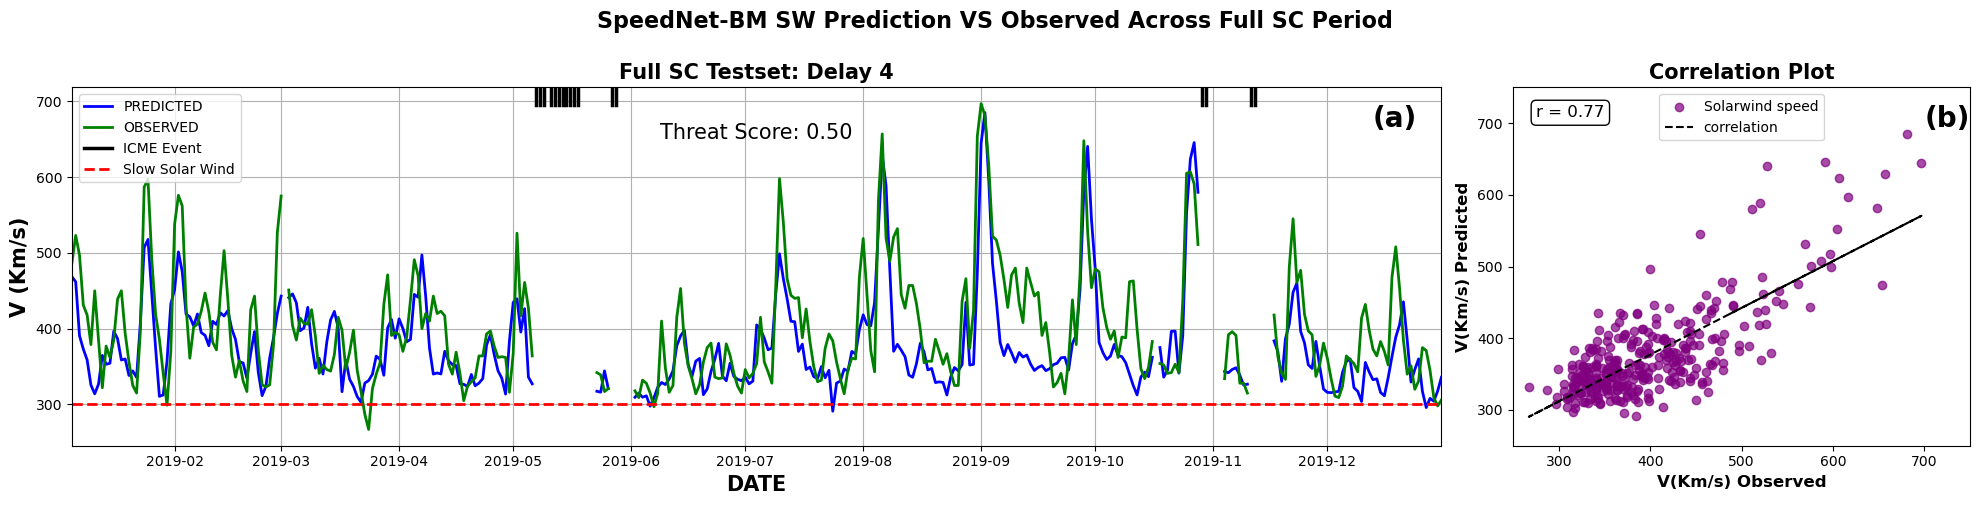

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20,5), gridspec_kw={'width_ratios': [3, 1]})
# fig.tight_layout(pad=4.0)
        
plt.plot()
plt.style.use('default')

fig.suptitle(f"SpeedNet-BM SW Prediction VS Observed Across Full SC Period", fontsize = 16, fontweight = "bold", y=1.0)

# FULL PERIOD(2019)
ax[0].plot(full_cycle_period_case_2['date'],full_cycle_period_case_2["test_predicted"],  linestyle='-', color='b', linewidth=2,  label='PREDICTED')
ax[0].plot(full_cycle_period_case_2['date'],full_cycle_period_case_2["test_original"],  linestyle='-', color='g', linewidth=2,  label='OBSERVED')
for i, icme_date in enumerate(full_icme_list):
    ax[0].axvline(x=icme_date, color='black', linestyle='-', ymax=1, ymin=0.95, linewidth=2.5, label='ICME Event' if i == 0 else "")
ax[0].set_title(f'Full SC Testset: Delay {full_period_num_delay+1}', fontsize = 15, fontweight = "bold")
ax[0].set_xlabel('DATE', fontsize = 15, fontweight = "bold")
ax[0].set_ylabel('V (Km/s)', fontsize = 15, fontweight = "bold")
ax[0].axhline(y=300, color='red', linestyle='--', linewidth=2, label='Slow Solar Wind')
ax[0].grid("on")
ax[0].text(0.5, 0.9, f'Threat Score: {full_2019_threat_score_case_2:.2f}', transform=ax[0].transAxes, fontsize=15,va='top', ha='center')
ax[0].text(0.95, 0.95, '(a)', transform=ax[0].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[0].set_xlim(full_cycle_period_case_2['date'].iloc[0], full_cycle_period_case_2['date'].iloc[-1])
ax[0].legend(loc='upper left')

# Correlation plot in the 2019 Only
ax[1].scatter(full_cycle_period_case_2["test_original"], full_cycle_period_case_2["test_predicted"], alpha=0.7, color='purple', label="Solarwind speed")

# Add correlation line 
obs_cleaned_full_2019_SC_case_2, pred_cleaned_full_2019_SC_case_2, fitted_y_full_2019_SC_case_2, slope_full_2019_SC_case_2, intercept_full_2019_SC_case_2 = linear_fit(full_cycle_period_case_2)
ax[1].plot(obs_cleaned_full_2019_SC_case_2, fitted_y_full_2019_SC_case_2, color='black', linestyle='--', label="correlation")
ax[1].set_title(f"Correlation Plot", fontsize = 15, fontweight = "bold")
ax[1].set_xlabel("V(Km/s) Observed" , fontsize = 12, fontweight = "bold")
ax[1].set_ylabel("V(Km/s) Predicted" , fontsize = 12, fontweight = "bold")
ax[1].text(0.05, 0.95, f"r = {full_corr_coef_2019_case_2:.2f}", transform=ax[1].transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white"))
ax[1].text(0.9, 0.95, '(b)', transform=ax[1].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax[1].set_xlim(250, 750)
ax[1].set_ylim(250, 750)
ax[1].legend(loc='upper center')


plt.subplots_adjust(top=0.7)
plt.subplots_adjust(hspace=0.5)
# # Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.savefig("Full_cycle_SpeedNet_BM_prediction_with_correlation.png")
plt.show()


#### Quantitative Analysis of the Activation Map across HSS Peak Period (August 28 - September 05, 2019)

In [32]:
SN_list = []
Mean_list = []
max_list = []
min_list = []
Original_solar_wind = []
predicted_solar_wind = []
wind_date = []
for i in range(len(Longer_HSS_full_period_random_selection)):
    Hss_full_period_img_cam, Hss_full_period_value = gradcamm(Longer_HSS_full_period_random_selection[i].reshape(1,256, 256, 1), best_model_full_period)
    SN_list.append(i+1)
    wind_date.append(list(full_period_Test_timeseries_date)[longer_HSS_full_period_indices_rand[i]+(full_period_num_delay+1)])
    Mean_list.append(np.mean(Hss_full_period_img_cam))
    max_list.append(np.max(Hss_full_period_img_cam))
    min_list.append(np.min(Hss_full_period_img_cam))
    Original_solar_wind.append(full_period_test_velocity_out[longer_HSS_full_period_indices_rand[i]])
    predicted_solar_wind.append(Hss_full_period_value)

case_2_activation_df = pd.DataFrame({
    'Map_index': SN_list,
    'Wind_date': wind_date,
    'Mean_act' : Mean_list,
    'Max_act': max_list,
    'Min_act': min_list,
    'Original_HSS': tf.squeeze(Original_solar_wind),
    'Predicted_HSS': tf.squeeze(predicted_solar_wind)
})
case_2_activation_df.to_csv('HSS_Case_2_Gradcam_activation_metrics.csv')

In [33]:
case_2_activation_df.head()

Map_index              Wind_date  Mean_act   Max_act   Min_act  \
0          1  [2019-08-28 00:00:00]  2.474426  9.091382  1.806414   
1          2  [2019-08-29 00:00:00]  1.980391  6.707166  1.378552   
2          3  [2019-08-30 00:00:00]  1.884396  6.098360  1.337019   
3          4  [2019-08-31 00:00:00]  2.423810  8.410024  1.662466   
4          5  [2019-09-01 00:00:00]  2.734118  9.248539  1.779928   

   Original_HSS  Predicted_HSS  
0         466.0     434.799469  
1         374.0     352.019562  
2         424.0     352.885864  
3         654.0     473.737152  
4         697.0     644.751831

In [34]:
case_2_activation_df.tail()

Map_index              Wind_date  Mean_act   Max_act   Min_act  \
4          5  [2019-09-01 00:00:00]  2.734118  9.248539  1.779928   
5          6  [2019-09-02 00:00:00]  3.051386  9.786817  1.870043   
6          7  [2019-09-03 00:00:00]  3.037505  9.715175  1.857342   
7          8  [2019-09-04 00:00:00]  2.743687  8.597581  1.598421   
8          9  [2019-09-05 00:00:00]  2.535861  8.039005  1.514314   

   Original_HSS  Predicted_HSS  
4         697.0     644.751831  
5         681.0     685.167725  
6         616.0     596.314697  
7         522.0     485.831421  
8         517.0     436.774200